<a href="https://colab.research.google.com/github/lmbaezp/HackSport/blob/main/TelecomX_Parte2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##📌 EXTRACCIÓN

In [83]:
# ===== LIBRERÍAS BÁSICAS PARA ANÁLISIS DE DATOS =====
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import json
import requests
from pandas import json_normalize
from IPython.display import Image, display
import warnings
warnings.filterwarnings('ignore')

# ===== LIBRERÍAS PARA PREPROCESSING =====
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ===== LIBRERÍAS PARA DIVISIÓN DE DATOS =====
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# ===== LIBRERÍAS PARA MODELOS =====
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# ===== LIBRERÍAS PARA EVALUACIÓN =====
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score, log_loss, auc
)

# ===== LIBRERÍAS PARA ANÁLISIS DE CORRELACIÓN =====
from scipy.stats import chi2_contingency, pearsonr, spearmanr
from sklearn.feature_selection import SelectKBest, chi2, f_classif

# ===== LIBRERÍAS PARA INTERPRETACIÓN =====
from sklearn.inspection import permutation_importance
# Para visualizar árboles de decisión
from sklearn.tree import plot_tree

# # ===== CONFIGURACIÓN PARA GRÁFICOS =====
# plt.style.use('default')
# sns.set_palette("husl")
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', 1000)

### Lectura de los datos

In [84]:
url = 'https://raw.githubusercontent.com/alura-cursos/challenge2-data-science-LATAM/refs/heads/main/TelecomX_Data.json'

In [85]:
# Leer los datos desde la URL
response = requests.get(url)

# Verificar que se haya leído correctamente
if response.status_code == 200:
    data = response.json()
else:
    print("Error al cargar los datos:", response.status_code)

type(data)

list

### Normalizar el JSON

In [86]:
# Normalizar el JSON si hay anidamientos
df = json_normalize(data)
df.head()
#df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer.gender            7267 non-null   object 
 3   customer.SeniorCitizen     7267 non-null   int64  
 4   customer.Partner           7267 non-null   object 
 5   customer.Dependents        7267 non-null   object 
 6   customer.tenure            7267 non-null   int64  
 7   phone.PhoneService         7267 non-null   object 
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non-null   object 
 13  internet.TechSupport       7267 non-null   objec

##🛠️ Preparación de los Datos

### Correción valores en blanco de la variable objetivo

In [87]:
print(df[df['Churn'] == ''])

      customerID Churn customer.gender  customer.SeniorCitizen  \
30    0047-ZHDTW                Female                       0   
75    0120-YZLQA                  Male                       0   
96    0154-QYHJU                  Male                       0   
98    0162-RZGMZ                Female                       1   
175   0274-VVQOQ                  Male                       1   
...          ...   ...             ...                     ...   
7158  9840-GSRFX                Female                       0   
7180  9872-RZQQB                Female                       0   
7211  9920-GNDMB                  Male                       0   
7239  9955-RVWSC                Female                       0   
7247  9966-VYRTZ                Female                       0   

     customer.Partner customer.Dependents  customer.tenure phone.PhoneService  \
30                 No                  No               11                Yes   
75                 No                  No    

**Se eliminan los 224 registros que en la variable CHURN estan ''**, porque al ser la variable de interés imputarlos puede afectar el grado de predicción del modelo

In [88]:
df = df.drop(df[df['Churn'] == ''].index)
print(df[df['Churn'] == ''])

Empty DataFrame
Columns: [customerID, Churn, customer.gender, customer.SeniorCitizen, customer.Partner, customer.Dependents, customer.tenure, phone.PhoneService, phone.MultipleLines, internet.InternetService, internet.OnlineSecurity, internet.OnlineBackup, internet.DeviceProtection, internet.TechSupport, internet.StreamingTV, internet.StreamingMovies, account.Contract, account.PaperlessBilling, account.PaymentMethod, account.Charges.Monthly, account.Charges.Total]
Index: []

[0 rows x 21 columns]


In [89]:
df_columns = df.columns
for i in list(df_columns):
  print(f'{i} - {df[i].unique()}')


customerID - ['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
Churn - ['No' 'Yes']
customer.gender - ['Female' 'Male']
customer.SeniorCitizen - [0 1]
customer.Partner - ['Yes' 'No']
customer.Dependents - ['Yes' 'No']
customer.tenure - [ 9  4 13  3 71 63  7 65 54 72  5 56 34  1 45 50 23 55 26 69 37 49 66 67
 20 43 59 12 27  2 25 29 14 35 64 39 40 11  6 30 70 57 58 16 32 33 10 21
 61 15 44 22 24 19 47 62 46 52  8 60 48 28 41 53 68 31 36 17 18 51 38 42
  0]
phone.PhoneService - ['Yes' 'No']
phone.MultipleLines - ['No' 'Yes' 'No phone service']
internet.InternetService - ['DSL' 'Fiber optic' 'No']
internet.OnlineSecurity - ['No' 'Yes' 'No internet service']
internet.OnlineBackup - ['Yes' 'No' 'No internet service']
internet.DeviceProtection - ['No' 'Yes' 'No internet service']
internet.TechSupport - ['Yes' 'No' 'No internet service']
internet.StreamingTV - ['Yes' 'No' 'No internet service']
internet.StreamingMovies - ['No' 'Yes' 'No internet service']
ac

Se observa que la variable tenure hay registros con valor 0, esto implicaría personas recientes que no parecen ofrecer valor para el análisis de personas que se dan de baja.

### Eliminación valores en = de la variable 'tenure'

In [90]:
len(df[df['customer.tenure'] == 0])

11

In [91]:
len(df[(df['customer.tenure'] == 0) & (df['Churn'] == 'No') ])

11

En efecto, según lo observado en las celdas anteriores esos 11 registros con Tenure 0 tienen también Churn negativo, por tanto, se proecede a eliminar esos 11 registros

In [92]:
df = df.drop(df[df['customer.tenure'] == 0].index)
print(df[df['customer.tenure'] == 0])

Empty DataFrame
Columns: [customerID, Churn, customer.gender, customer.SeniorCitizen, customer.Partner, customer.Dependents, customer.tenure, phone.PhoneService, phone.MultipleLines, internet.InternetService, internet.OnlineSecurity, internet.OnlineBackup, internet.DeviceProtection, internet.TechSupport, internet.StreamingTV, internet.StreamingMovies, account.Contract, account.PaperlessBilling, account.PaymentMethod, account.Charges.Monthly, account.Charges.Total]
Index: []

[0 rows x 21 columns]


Se observan además variables que pueden presentar un problema para la elabroación de modelos predictivos por su relación, dado que al hacer el encoding crearían redundancia, lo cual implicaría colinealidad:



```
phone.PhoneService - ['Yes' 'No']
phone.MultipleLines - ['No' 'Yes' 'No phone service']
internet.InternetService - ['DSL' 'Fiber optic' 'No']
internet.OnlineSecurity - ['No' 'Yes' 'No internet service']
internet.OnlineBackup - ['Yes' 'No' 'No internet service']
internet.DeviceProtection - ['No' 'Yes' 'No internet service']
internet.TechSupport - ['Yes' 'No' 'No internet service']
internet.StreamingTV - ['Yes' 'No' 'No internet service']
internet.StreamingMovies - ['No' 'Yes' 'No internet service']
```

Por ello se decide reemplazar los valores 'No phone service' y 'No internet service' por no



### Modificación valores 'no phone service' y 'no internet service' por no

In [93]:
# Para variables de Internet
internet_vars = [
    'internet.OnlineSecurity', 'internet.OnlineBackup',
    'internet.DeviceProtection', 'internet.TechSupport',
    'internet.StreamingTV', 'internet.StreamingMovies'
]
for var in internet_vars:
    df[var] = df[var].replace('No internet service', 'No')
    print(f"{var}: valores únicos ahora son {df[var].unique()}")

internet.OnlineSecurity: valores únicos ahora son ['No' 'Yes']
internet.OnlineBackup: valores únicos ahora son ['Yes' 'No']
internet.DeviceProtection: valores únicos ahora son ['No' 'Yes']
internet.TechSupport: valores únicos ahora son ['Yes' 'No']
internet.StreamingTV: valores únicos ahora son ['Yes' 'No']
internet.StreamingMovies: valores únicos ahora son ['No' 'Yes']


In [94]:
df['phone.MultipleLines'] = df['phone.MultipleLines'].replace('No phone service', 'No')
print(f"phone.MultipleLines: valores únicos ahora son {df['phone.MultipleLines'].unique()}")

phone.MultipleLines: valores únicos ahora son ['No' 'Yes']


También hay otras dos variables que pueden causar problemas en el modelo predictivo: `'account.Charges.Monthly' y  'account.Charges.Total'`. Esto porque podría deducirse que el valor Total es igual al número de meses que lleva el cliente por el valor del cargo mensual.

Se hizo la prueba y si bien no dió exactamente igual, los resultados son bastante cercanos. Esto es interesante porque, si asumimos que la varaible `'account.Charges.Total'` tiene un valor mayor porque es el valor calculado hasta el día que se sacó la base de datos, pueden existir datos que no sean del todo reales, porque si un cliente se dio de baja antes de la fecha de la recogida de datos, ese valor no sería real. Como no se tiene claridad de la realización del cálculo exacto, lo más prudente es eliminar esa variable.

Además, esas dos variables miden lo mismo, lo cual puede confundir al modelo. Y la variable `Charges.Monthly` ya captura el patrón de gasto del cliente. De hecho, desde la opinión personal de quien ecribe, resulta mejor el uso de `Charges.Monthly`, porque tomese el caso donde hay dos usuarios con total alto, el uno debido a su largo tiempo de permanencia pero con un valor de producto bajo, mientras que otro por su pago alto de los servicios a pesar de tener muy poco tiempo en la empresa. Entonces, resultaría más diciente la información de la columna `Charges.Monthly` para el propósito del análisis.




In [95]:
correlation = df['account.Charges.Monthly'].corr(df['account.Charges.Total'])
print(f"\n📊 Correlación Charges.Monthly vs Charges.Total: {correlation:.3f}")


📊 Correlación Charges.Monthly vs Charges.Total: 0.651


Para tener un soporte fáctico de la hipótesis detallada anteriormente se calcula el coeficiente de correlación de Pearson entre las variables mencionadas, obteniendo un valor de 0.651, indicando una correlación lineal moderada-alta, lo cual a su vez influiría en problemas de colinealidad.

Entonces, bajo los argumentos ya expresados, se elimina la columna `Charges.Monthly` de los datos. Y de igual forma la columna que sirve como identificador `customer.Id`, porque al ser un identificador no aporta información valiosa para lo que se pretende con el modelo.

### Eliminación variables 'customerID' y 'account.Charges.Total'

In [96]:
columns_to_drop = ['customerID', 'account.Charges.Total']
df_clean = df.drop(columns = columns_to_drop)
df_clean.columns

Index(['Churn', 'customer.gender', 'customer.SeniorCitizen',
       'customer.Partner', 'customer.Dependents', 'customer.tenure',
       'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService',
       'internet.OnlineSecurity', 'internet.OnlineBackup',
       'internet.DeviceProtection', 'internet.TechSupport',
       'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract',
       'account.PaperlessBilling', 'account.PaymentMethod',
       'account.Charges.Monthly'],
      dtype='object')

### Revisión de balance de datos

In [97]:
df['Churn'].value_counts()

,count
Churn,
No,5163
Yes,1869


Según la literatura si hay un desbalance moderado de los datos, para tratar ese problema se decide utilizar el parámetro `class_weight='balanced'` para la elaboración de los modelos predictivos

### Resumen descriptivo de los datos

📊 Creando gráficos para variables CUSTOMER...


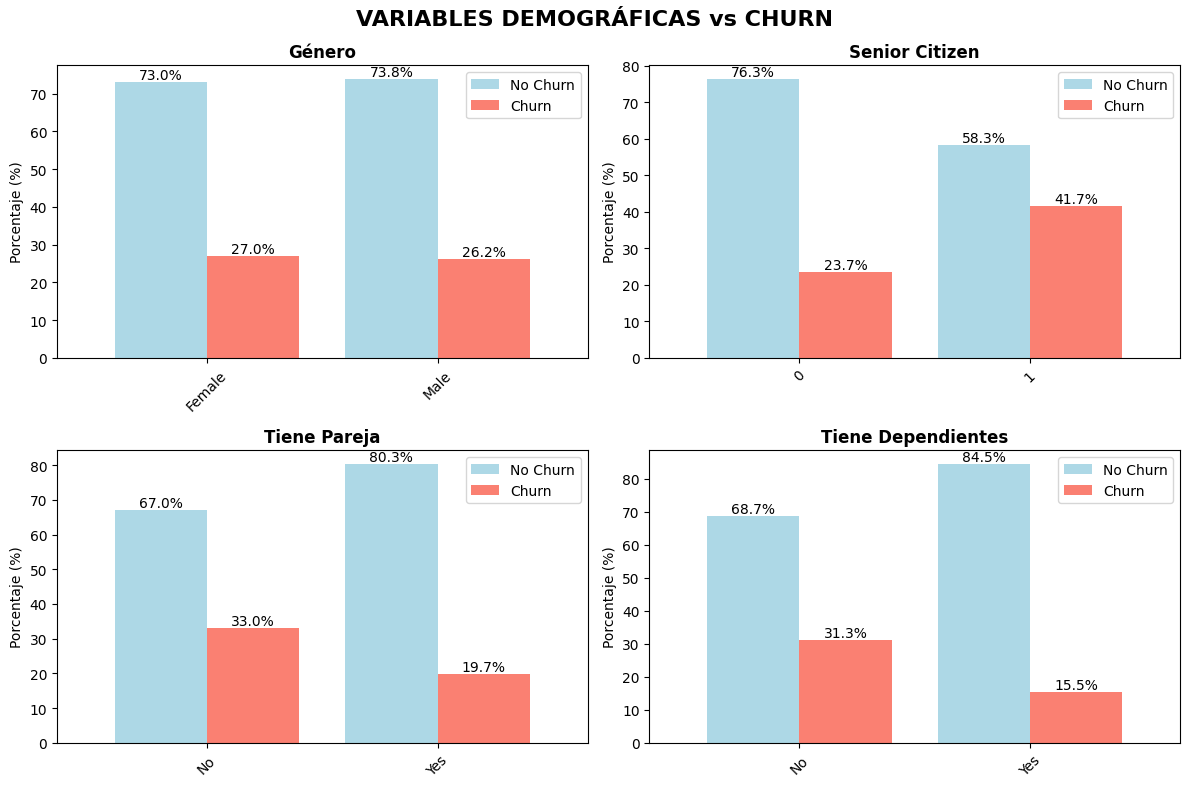

📊 Creando gráficos para variables PHONE...


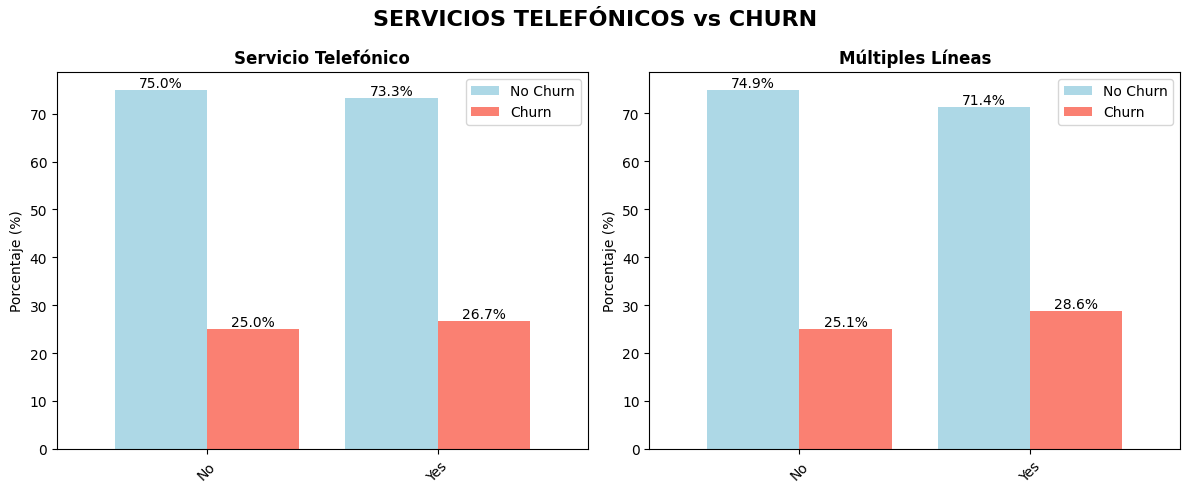

📊 Creando gráficos para variables INTERNET...


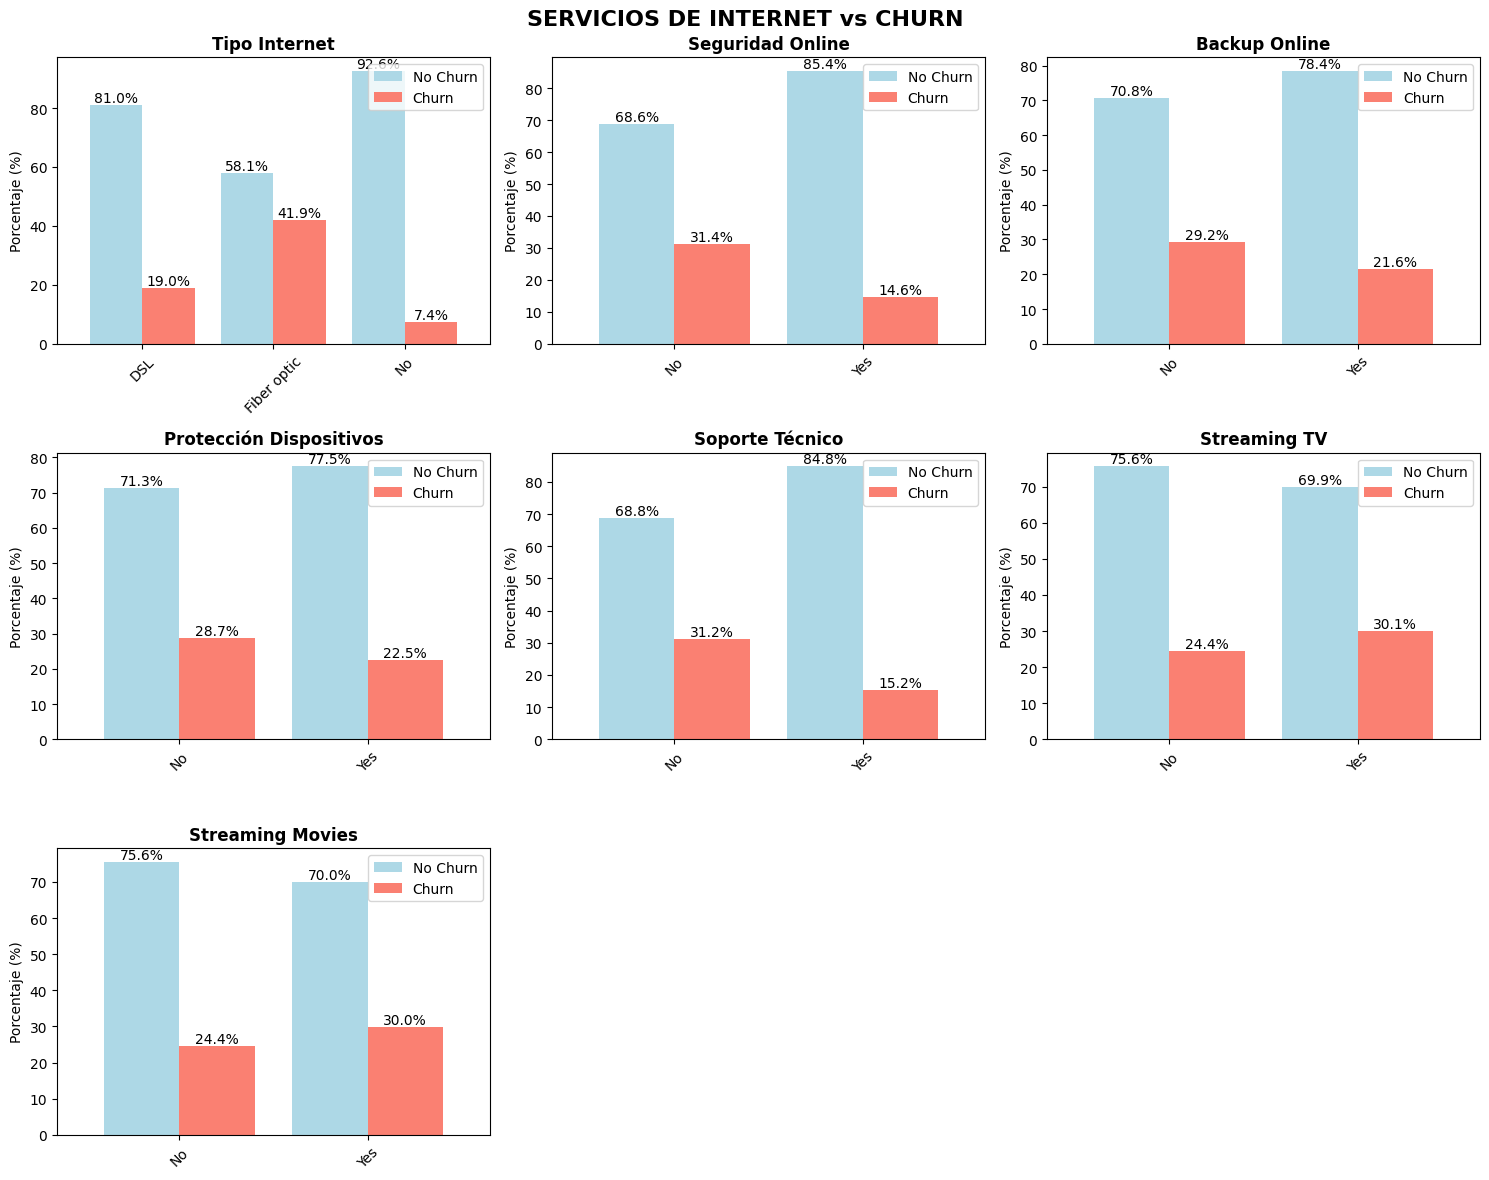

📊 Creando gráficos para variables ACCOUNT...


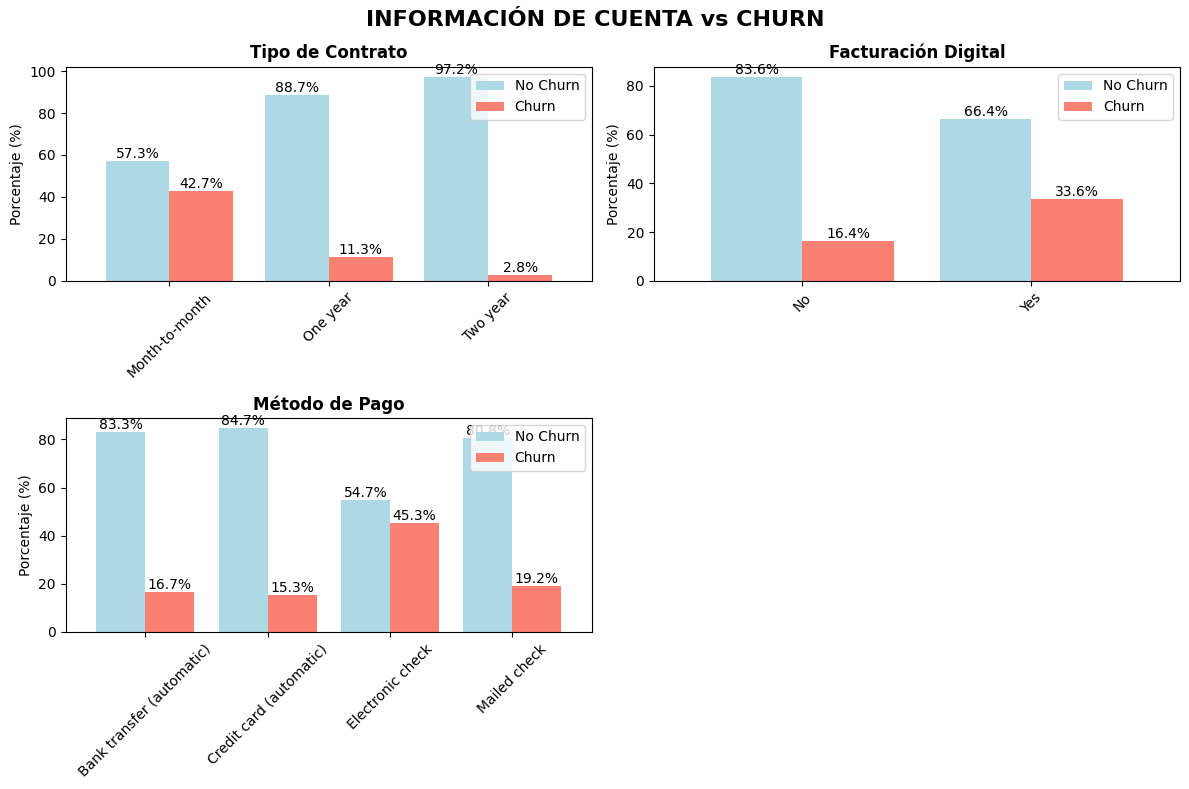

📊 Creando gráficos para variables NUMÉRICAS...


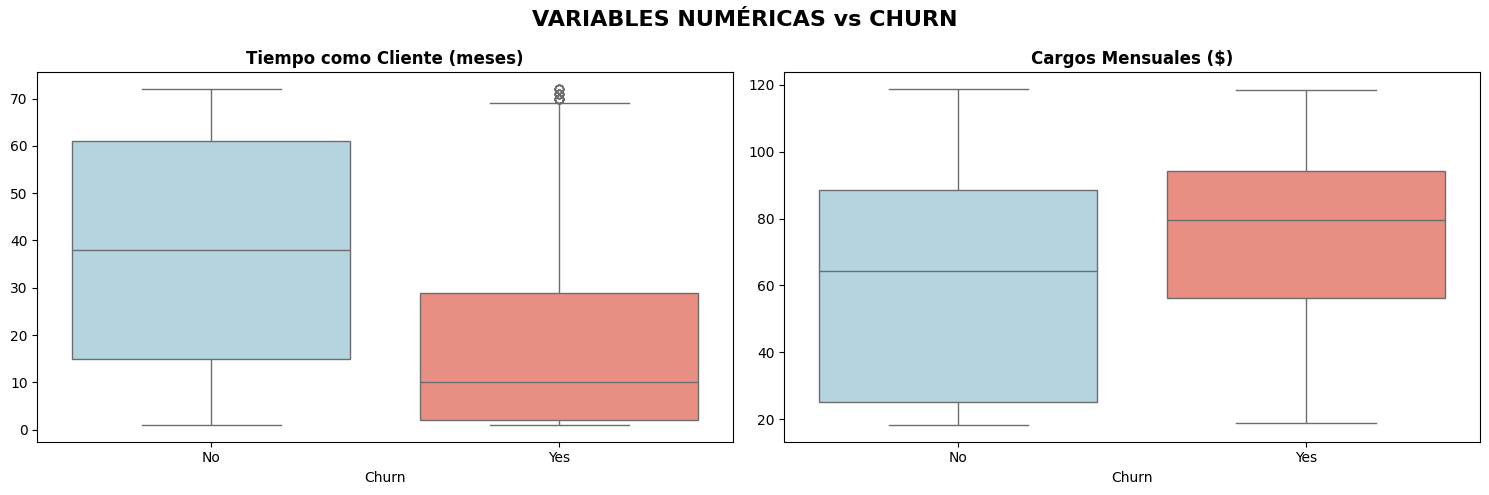

In [98]:
plt.style.use('default')
sns.set_palette("Set2")

# ===== FUNCIÓN PARA GRÁFICOS CATEGÓRICOS =====
def plot_categorical_vs_churn(ax, var_name, title_name):
    # Crear tabla cruzada con porcentajes
    crosstab = pd.crosstab(df_clean[var_name], df_clean['Churn'], normalize='index') * 100

    # Gráfico de barras apiladas
    crosstab.plot(kind='bar', ax=ax, color=['lightblue', 'salmon'], width=0.8)

    ax.set_title(f'{title_name}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Porcentaje (%)')
    ax.set_xlabel('')
    ax.legend(['No Churn', 'Churn'], loc='upper right')
    ax.tick_params(axis='x', rotation=45)

    # Añadir valores en las barras
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', fontsize=10)

# ===== FUNCIÓN PARA GRÁFICOS NUMÉRICOS =====
def plot_numerical_vs_churn(ax, var_name, title_name):
    sns.boxplot(data=df_clean, x='Churn', y=var_name, ax=ax, palette=['lightblue', 'salmon'])
    ax.set_title(f'{title_name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Churn')
    ax.set_ylabel('')

# ===== 1. VARIABLES CUSTOMER =====
print("📊 Creando gráficos para variables CUSTOMER...")

customer_vars = ['customer.gender', 'customer.SeniorCitizen', 'customer.Partner', 'customer.Dependents']
fig1, axes1 = plt.subplots(2, 2, figsize=(12, 8))
axes1 = axes1.flatten()

titles1 = ['Género', 'Senior Citizen', 'Tiene Pareja', 'Tiene Dependientes']

for i, (var, title) in enumerate(zip(customer_vars, titles1)):
    plot_categorical_vs_churn(axes1[i], var, title)

plt.suptitle('VARIABLES DEMOGRÁFICAS vs CHURN', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('var_demograficas_churn.png')
plt.show()

# ===== 2. VARIABLES PHONE =====
print("📊 Creando gráficos para variables PHONE...")

phone_vars = ['phone.PhoneService', 'phone.MultipleLines']
fig2, axes2 = plt.subplots(1, 2, figsize=(12, 5))

titles2 = ['Servicio Telefónico', 'Múltiples Líneas']

for i, (var, title) in enumerate(zip(phone_vars, titles2)):
    plot_categorical_vs_churn(axes2[i], var, title)

plt.suptitle('SERVICIOS TELEFÓNICOS vs CHURN', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('serv_telefonicos_churn.png')
plt.show()

# ===== 3. VARIABLES INTERNET =====
print("📊 Creando gráficos para variables INTERNET...")

internet_vars = [
    'internet.InternetService', 'internet.OnlineSecurity', 'internet.OnlineBackup',
    'internet.DeviceProtection', 'internet.TechSupport', 'internet.StreamingTV',
    'internet.StreamingMovies'
]

fig3, axes3 = plt.subplots(3, 3, figsize=(15, 12))
axes3 = axes3.flatten()

titles3 = [
    'Tipo Internet', 'Seguridad Online', 'Backup Online',
    'Protección Dispositivos', 'Soporte Técnico', 'Streaming TV',
    'Streaming Movies'
]

for i, (var, title) in enumerate(zip(internet_vars, titles3)):
    plot_categorical_vs_churn(axes3[i], var, title)

# Ocultar los ejes extra
for i in range(len(internet_vars), len(axes3)):
    axes3[i].set_visible(False)

plt.suptitle('SERVICIOS DE INTERNET vs CHURN', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('serv_internet_churn.png')
plt.show()

# ===== 4. VARIABLES ACCOUNT =====
print("📊 Creando gráficos para variables ACCOUNT...")

account_vars = ['account.Contract', 'account.PaperlessBilling', 'account.PaymentMethod']
fig4, axes4 = plt.subplots(2, 2, figsize=(12, 8))
axes4 = axes4.flatten()

titles4 = ['Tipo de Contrato', 'Facturación Digital', 'Método de Pago']

for i, (var, title) in enumerate(zip(account_vars, titles4)):
    plot_categorical_vs_churn(axes4[i], var, title)

# Ocultar el eje extra
axes4[3].set_visible(False)

plt.suptitle('INFORMACIÓN DE CUENTA vs CHURN', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('account_churn.png')
plt.show()

# ===== 5. VARIABLES NUMÉRICAS =====
print("📊 Creando gráficos para variables NUMÉRICAS...")

numerical_vars = ['customer.tenure', 'account.Charges.Monthly']
fig5, axes5 = plt.subplots(1, 2, figsize=(15, 5))

titles5 = ['Tiempo como Cliente (meses)', 'Cargos Mensuales ($)', 'Cargos Totales ($)']

for i, (var, title) in enumerate(zip(numerical_vars, titles5)):
    plot_numerical_vs_churn(axes5[i], var, title)

plt.suptitle('VARIABLES NUMÉRICAS vs CHURN', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('var_numericas_churn.png')
plt.show()

In [99]:
# ===== RESUMEN ESTADÍSTICO =====
print(f"\n" + "="*60)
print("RESUMEN DE INSIGHTS PRINCIPALES")
print("="*60)

# Calcular churn rate general
churn_rate = (df['Churn'] == 'Yes').mean() * 100
print(f"📊 Churn Rate General: {churn_rate:.1f}%")

print(f"\n🔍 PRINCIPALES DIFERENCIAS POR CATEGORÍA:")
for var in ['account.Contract', 'internet.InternetService', 'customer.Partner']:
    if var in df.columns:
        crosstab = pd.crosstab(df[var], df['Churn'], normalize='index') * 100
        print(f"\n{var}:")
        for categoria in crosstab.index:
            churn_pct = crosstab.loc[categoria, 'Yes']
            print(f"  {categoria}: {churn_pct:.1f}% churn")

print(f"\n🔢 VARIABLES NUMÉRICAS - PROMEDIOS:")
for var in numerical_vars[:2]:  # Solo las principales
    if var in df.columns:
        mean_no_churn = df[df['Churn'] == 'No'][var].mean()
        mean_churn = df[df['Churn'] == 'Yes'][var].mean()
        print(f"{var}:")
        print(f"  No Churn: {mean_no_churn:.1f}")
        print(f"  Churn: {mean_churn:.1f}")
        print(f"  Diferencia: {mean_churn - mean_no_churn:.1f}")

print(f"\n✅ Visualización completada - Revisa los gráficos para identificar patrones")


RESUMEN DE INSIGHTS PRINCIPALES
📊 Churn Rate General: 26.6%

🔍 PRINCIPALES DIFERENCIAS POR CATEGORÍA:

account.Contract:
  Month-to-month: 42.7% churn
  One year: 11.3% churn
  Two year: 2.8% churn

internet.InternetService:
  DSL: 19.0% churn
  Fiber optic: 41.9% churn
  No: 7.4% churn

customer.Partner:
  No: 33.0% churn
  Yes: 19.7% churn

🔢 VARIABLES NUMÉRICAS - PROMEDIOS:
customer.tenure:
  No Churn: 37.7
  Churn: 18.0
  Diferencia: -19.7
account.Charges.Monthly:
  No Churn: 61.3
  Churn: 74.4
  Diferencia: 13.1

✅ Visualización completada - Revisa los gráficos para identificar patrones


### Preprocesamiento de los datos para modelos predictivos

Encoding y creación de subconjuntos

#### Convirtiendo la variable 'Churn' en 0 y 1

In [100]:
# Variable objetivo
target = 'Churn'

# Variables categóricas (todas las object excepto Churn)
categorical_vars = [col for col in df_clean.columns if df_clean[col].dtype == 'object' and col != target]

# Variables numéricas
numerical_vars = [col for col in df_clean.columns if df_clean[col].dtype in ['int64', 'float64']]

# Convertir Churn a numérico: No=0, Yes=1
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_clean[target])
y_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

#### Crear X (variables predictoras)

In [101]:
# Crear X (variables predictoras)
X = df_clean.drop(columns=[target])

#### Encoding para variables categóricas

In [102]:
# Identificar variables categóricas binarias vs múltiples
binary_vars = []
multi_vars = []

for var in categorical_vars:
    unique_vals = X[var].nunique()
    if unique_vals == 2:
        binary_vars.append(var)
    else:
        multi_vars.append(var)

# Crear transformador
preprocessor_scaler = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_vars),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars)
    ],
    remainder='passthrough'
)

preprocessor = ColumnTransformer(
    transformers=[
         ('num', FunctionTransformer(), numerical_vars),
         ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars)
    ],
    remainder='passthrough'
)

# Ajustar y transformar
X_processed_scaler = preprocessor_scaler.fit_transform(X)
X_processed = preprocessor.fit_transform(X)

# Obtener nombres de columnas después de one-hot encoding
feature_names = []

# Nombres de variables numéricas (se mantienen iguales)
feature_names.extend(numerical_vars)

# Nombres de variables categóricas (después de one-hot)
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_vars)
feature_names.extend(cat_feature_names)

# Crear DataFrame procesado
X_processed_df = pd.DataFrame(X_processed, columns=feature_names)
X_processed_scaler_df = pd.DataFrame(X_processed_scaler, columns=feature_names)


#### Divisón train, test, validation variables numericas no escaladas

In [103]:
# División estratificada para mantener proporción de churn
X_trainTest, X_validation, y_trainTest, y_validation = train_test_split(
    X_processed, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train, X_test, y_train, y_test = train_test_split(
    X_trainTest, y_trainTest,
    test_size=0.25,
    random_state=42,
    stratify=y_trainTest
)

print(f"División completada:")
print(f"   • Train: {X_train.shape[0]} registros ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   • Test:  {X_test.shape[0]} registros ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"   • Validation:  {X_validation.shape[0]} registros ({X_validation.shape[0]/len(X)*100:.1f}%)")
print(f"   • Features: {X_train.shape[1]} variables")

# Verificar distribución de churn en train/test
train_churn_rate = y_train.mean() * 100
test_churn_rate = y_test.mean() * 100
validation_churn_rate = y_validation.mean() * 100
original_churn_rate = y.mean() * 100
print(f"   • Churn rate train: {train_churn_rate:.1f}%")
print(f"   • Churn rate test:  {test_churn_rate:.1f}%")
print(f"   • Churn rate validation:  {validation_churn_rate:.1f}%")
print(f"   • Original Churn rate :  {original_churn_rate:.1f}%")

# Verificar que las proporciones están balanceadas
max_diff = max(abs(train_churn_rate - original_churn_rate),
               abs(test_churn_rate - original_churn_rate),
               abs(validation_churn_rate - original_churn_rate))

if max_diff < 2:  # Diferencia menor a 2%
    print(f"✅ Estratificación exitosa - diferencias < 2%")
else:
    print(f"⚠️  Revisar estratificación - diferencia máxima: {max_diff:.1f}%")

División completada:
   • Train: 4218 registros (60.0%)
   • Test:  1407 registros (20.0%)
   • Validation:  1407 registros (20.0%)
   • Features: 22 variables
   • Churn rate train: 26.6%
   • Churn rate test:  26.6%
   • Churn rate validation:  26.6%
   • Original Churn rate :  26.6%
✅ Estratificación exitosa - diferencias < 2%


#### Divisón train, test, validation variables numericas escaladas

In [104]:
# División estratificada para mantener proporción de churn
X_trainTest_scaler, X_validation_scaler, y_trainTest_scaler, y_validation_scaler = train_test_split(
    X_processed_scaler, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train_scaler, X_test_scaler, y_train_scaler, y_test_scaler = train_test_split(
    X_trainTest_scaler, y_trainTest_scaler,
    test_size=0.25,
    random_state=42,
    stratify=y_trainTest_scaler
)

print(f"División completada:")
print(f"   • Train: {X_train_scaler.shape[0]} registros ({X_train_scaler.shape[0]/len(X)*100:.1f}%)")
print(f"   • Test:  {X_test_scaler.shape[0]} registros ({X_test_scaler.shape[0]/len(X)*100:.1f}%)")
print(f"   • Validation:  {X_validation_scaler.shape[0]} registros ({X_validation_scaler.shape[0]/len(X)*100:.1f}%)")
print(f"   • Features: {X_train_scaler.shape[1]} variables")

# Verificar distribución de churn en train/test
train_scaler_churn_rate = y_train_scaler.mean() * 100
test_scaler_churn_rate = y_test_scaler.mean() * 100
validation_scaler_churn_rate = y_validation_scaler.mean() * 100
original_scaler_churn_rate = y.mean() * 100
print(f"   • Churn rate train scaler: {train_scaler_churn_rate:.1f}%")
print(f"   • Churn rate test scaler:  {test_scaler_churn_rate:.1f}%")
print(f"   • Churn rate validation scaler:  {validation_scaler_churn_rate:.1f}%")
print(f"   • Original Churn rate scaler :  {original_scaler_churn_rate:.1f}%")

# Verificar que las proporciones están balanceadas
max_diff = max(abs(train_scaler_churn_rate - original_scaler_churn_rate),
               abs(test_scaler_churn_rate - original_scaler_churn_rate),
               abs(validation_scaler_churn_rate - original_scaler_churn_rate))

if max_diff < 2:  # Diferencia menor a 2%
    print(f"✅ Estratificación exitosa - diferencias < 2%")
else:
    print(f"⚠️  Revisar estratificación - diferencia máxima: {max_diff:.1f}%")

División completada:
   • Train: 4218 registros (60.0%)
   • Test:  1407 registros (20.0%)
   • Validation:  1407 registros (20.0%)
   • Features: 22 variables
   • Churn rate train scaler: 26.6%
   • Churn rate test scaler:  26.6%
   • Churn rate validation scaler:  26.6%
   • Original Churn rate scaler :  26.6%
✅ Estratificación exitosa - diferencias < 2%


## ≡ Correlación entre las variables


1. CORRELACIÓN ENTRE VARIABLES NUMÉRICAS ORIGINALES:
--------------------------------------------------
Matriz de correlación numérica:
                         customer.tenure  account.Charges.Monthly
customer.tenure                 1.000000                 0.246862
account.Charges.Monthly         0.246862                 1.000000


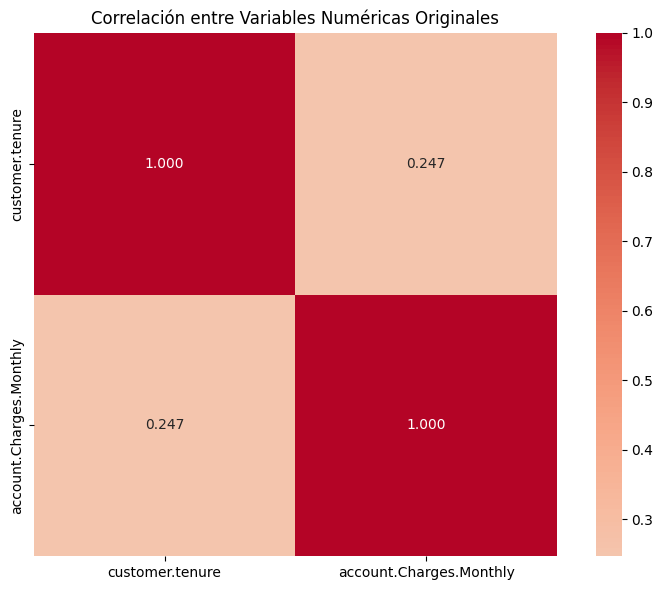

In [105]:
# ===== 1. CORRELACIÓN SOLO ENTRE VARIABLES NUMÉRICAS ORIGINALES =====
print("\n1. CORRELACIÓN ENTRE VARIABLES NUMÉRICAS ORIGINALES:")
print("-" * 50)

# Variables numéricas originales (antes de encoding)
numerical_original = ['customer.tenure', 'account.Charges.Monthly']

if len(numerical_original) > 1:
    corr_numerical = df[numerical_original].corr()
    print("Matriz de correlación numérica:")
    print(corr_numerical)

    # Visualizar
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_numerical, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.3f')
    plt.title('Correlación entre Variables Numéricas Originales')
    plt.tight_layout()
    plt.show()
else:
    print("Solo hay una variable numérica - no se puede calcular correlación")

El valor es bajo, de solo 0.247, indicando baja correlación enntre las dos variables numéricas predictoras


2. CORRELACIÓN DE CADA VARIABLE CON CHURN:
---------------------------------------------
TOP 10 variables más correlacionadas con Churn:
 1. customer.tenure                     | -0.354 | (abs: 0.354)
 2. internet.InternetService_Fiber optic |  0.307 | (abs: 0.307)
 3. account.Contract_Two year           | -0.302 | (abs: 0.302)
 4. account.PaymentMethod_Electronic check |  0.301 | (abs: 0.301)
 5. internet.InternetService_No         | -0.228 | (abs: 0.228)
 6. account.Charges.Monthly             |  0.193 | (abs: 0.193)
 7. account.PaperlessBilling_Yes        |  0.191 | (abs: 0.191)
 8. account.Contract_One year           | -0.178 | (abs: 0.178)
 9. internet.OnlineSecurity_Yes         | -0.171 | (abs: 0.171)
10. internet.TechSupport_Yes            | -0.165 | (abs: 0.165)

3. VISUALIZACIÓN DE CORRELACIONES CON CHURN:
---------------------------------------------


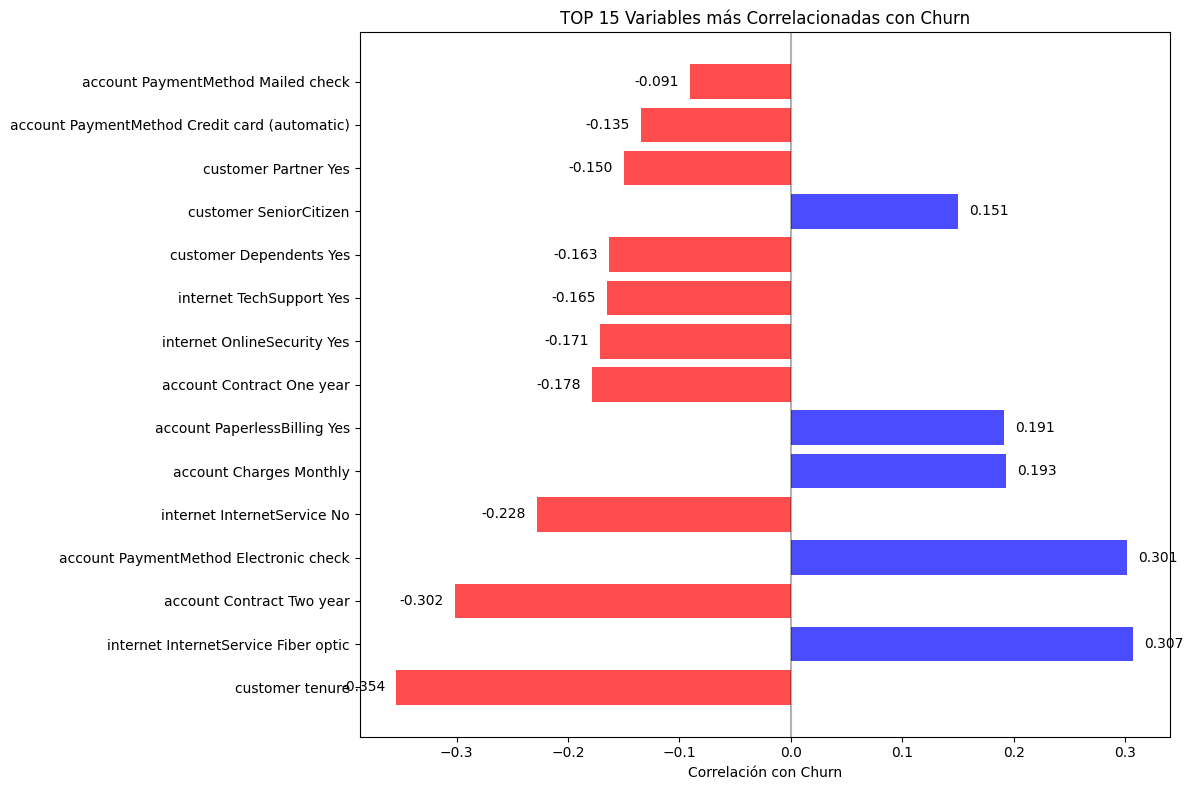

In [106]:
# ===== 2. CORRELACIÓN CON LA VARIABLE OBJETIVO (MUY ÚTIL) =====
print(f"\n2. CORRELACIÓN DE CADA VARIABLE CON CHURN:")
print("-" * 45)

# Convertir datos procesados a DataFrame si no lo están
if not isinstance(X_processed, pd.DataFrame):
    X_processed_df = pd.DataFrame(X_processed, columns=feature_names)
else:
    X_processed_df = X_processed

# Calcular correlación con target
correlation_with_churn = X_processed_df.corrwith(pd.Series(y, index=X_processed_df.index))

# Ordenar por valor absoluto (las más importantes)
correlation_sorted = correlation_with_churn.abs().sort_values(ascending=False)

print("TOP 10 variables más correlacionadas con Churn:")
for i, (var, corr_val) in enumerate(correlation_sorted.head(10).items(), 1):
    original_corr = correlation_with_churn[var]
    print(f"{i:2d}. {var:35} | {original_corr:6.3f} | (abs: {corr_val:.3f})")

# ===== 3. VISUALIZACIÓN DE TOP CORRELACIONES =====
print(f"\n3. VISUALIZACIÓN DE CORRELACIONES CON CHURN:")
print("-" * 45)

# Top 15 correlaciones
top_correlations = correlation_with_churn.abs().sort_values(ascending=False).head(15)
top_correlation_values = correlation_with_churn[top_correlations.index]

plt.figure(figsize=(12, 8))
colors = ['red' if x < 0 else 'blue' for x in top_correlation_values]
bars = plt.barh(range(len(top_correlation_values)), top_correlation_values, color=colors, alpha=0.7)

plt.yticks(range(len(top_correlation_values)),
           [name.replace('_', ' ').replace('.', ' ') for name in top_correlation_values.index])
plt.xlabel('Correlación con Churn')
plt.title('TOP 15 Variables más Correlacionadas con Churn')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Añadir valores en las barras
for i, (bar, val) in enumerate(zip(bars, top_correlation_values)):
    plt.text(val + (0.01 if val > 0 else -0.01), i, f'{val:.3f}',
             va='center', ha='left' if val > 0 else 'right')

plt.tight_layout()
plt.savefig('corr_churn.png')
plt.show()


In [107]:
# ===== 4. ANÁLISIS POR GRUPOS DE VARIABLES =====
print(f"\n4. ANÁLISIS POR GRUPOS DE VARIABLES:")
print("-" * 40)

# Separar variables por prefijo
groups = {
    'Customer': [col for col in correlation_with_churn.index if 'customer' in col.lower()],
    'Phone': [col for col in correlation_with_churn.index if 'phone' in col.lower()],
    'Internet': [col for col in correlation_with_churn.index if 'internet' in col.lower()],
    'Account': [col for col in correlation_with_churn.index if 'account' in col.lower()]
}

for group_name, group_vars in groups.items():
    if group_vars:
        print(f"\n{group_name} variables:")
        group_corr = correlation_with_churn[group_vars].abs().sort_values(ascending=False)
        for var in group_corr.head(3).index:  # Top 3 de cada grupo
            corr_val = correlation_with_churn[var]
            print(f"   • {var:30} | {corr_val:6.3f}")


4. ANÁLISIS POR GRUPOS DE VARIABLES:
----------------------------------------

Customer variables:
   • customer.tenure                | -0.354
   • customer.Dependents_Yes        | -0.163
   • customer.SeniorCitizen         |  0.151

Phone variables:
   • phone.MultipleLines_Yes        |  0.040
   • phone.PhoneService_Yes         |  0.012

Internet variables:
   • internet.InternetService_Fiber optic |  0.307
   • internet.InternetService_No    | -0.228
   • internet.OnlineSecurity_Yes    | -0.171

Account variables:
   • account.Contract_Two year      | -0.302
   • account.PaymentMethod_Electronic check |  0.301
   • account.Charges.Monthly        |  0.193


En problemas de Churn, correlaciones de 0.2-0.4 son consideradas moderadas a fuertes. Raramente se ven correlaciones >0.5 porque el comportamiento humano es complejo.

En este sentido, según el análisis de correlación de las variables dependientes con la la variable independiente (Churn), hay correlaciones bastante buenas para el análisis.

**Correlaciones negativas fuertes (factores protectores):**

- customer.tenure (-0.354): Clientes con más tiempo tienden a quedarse
- account.Contract_Two year (-0.302): Contratos largos reducen el churn
- internet.InternetService_No (-0.228): No tener internet reduce probabilidad de irse

**Correlaciones positivas fuertes (factores de riesgo):**

- internet.InternetService_Fiber optic (0.307): Fibra óptica aumenta churn
- account.PaymentMethod_Electronic check (0.301): Este método de pago es riesgoso



## 🔍 Análisis de Multicolinealidad

Dado que se va a calcular la matriz de correlación entre las variables dependientes, y a sabiendas que ese valor es invariante al escalado, y que el escalado puede afectar la interpretación, se utilizarán los datos sin escalar con el fin de observar las relaciones "naturales" entre esas variables

In [108]:
list(X_processed_df.columns)



['customer.SeniorCitizen',
 'customer.tenure',
 'account.Charges.Monthly',
 'customer.gender_Male',
 'customer.Partner_Yes',
 'customer.Dependents_Yes',
 'phone.PhoneService_Yes',
 'phone.MultipleLines_Yes',
 'internet.InternetService_Fiber optic',
 'internet.InternetService_No',
 'internet.OnlineSecurity_Yes',
 'internet.OnlineBackup_Yes',
 'internet.DeviceProtection_Yes',
 'internet.TechSupport_Yes',
 'internet.StreamingTV_Yes',
 'internet.StreamingMovies_Yes',
 'account.Contract_One year',
 'account.Contract_Two year',
 'account.PaperlessBilling_Yes',
 'account.PaymentMethod_Credit card (automatic)',
 'account.PaymentMethod_Electronic check',
 'account.PaymentMethod_Mailed check']

🔍 ANÁLISIS COMPLETO DE MULTICOLINEALIDAD
Variables independientes: 22


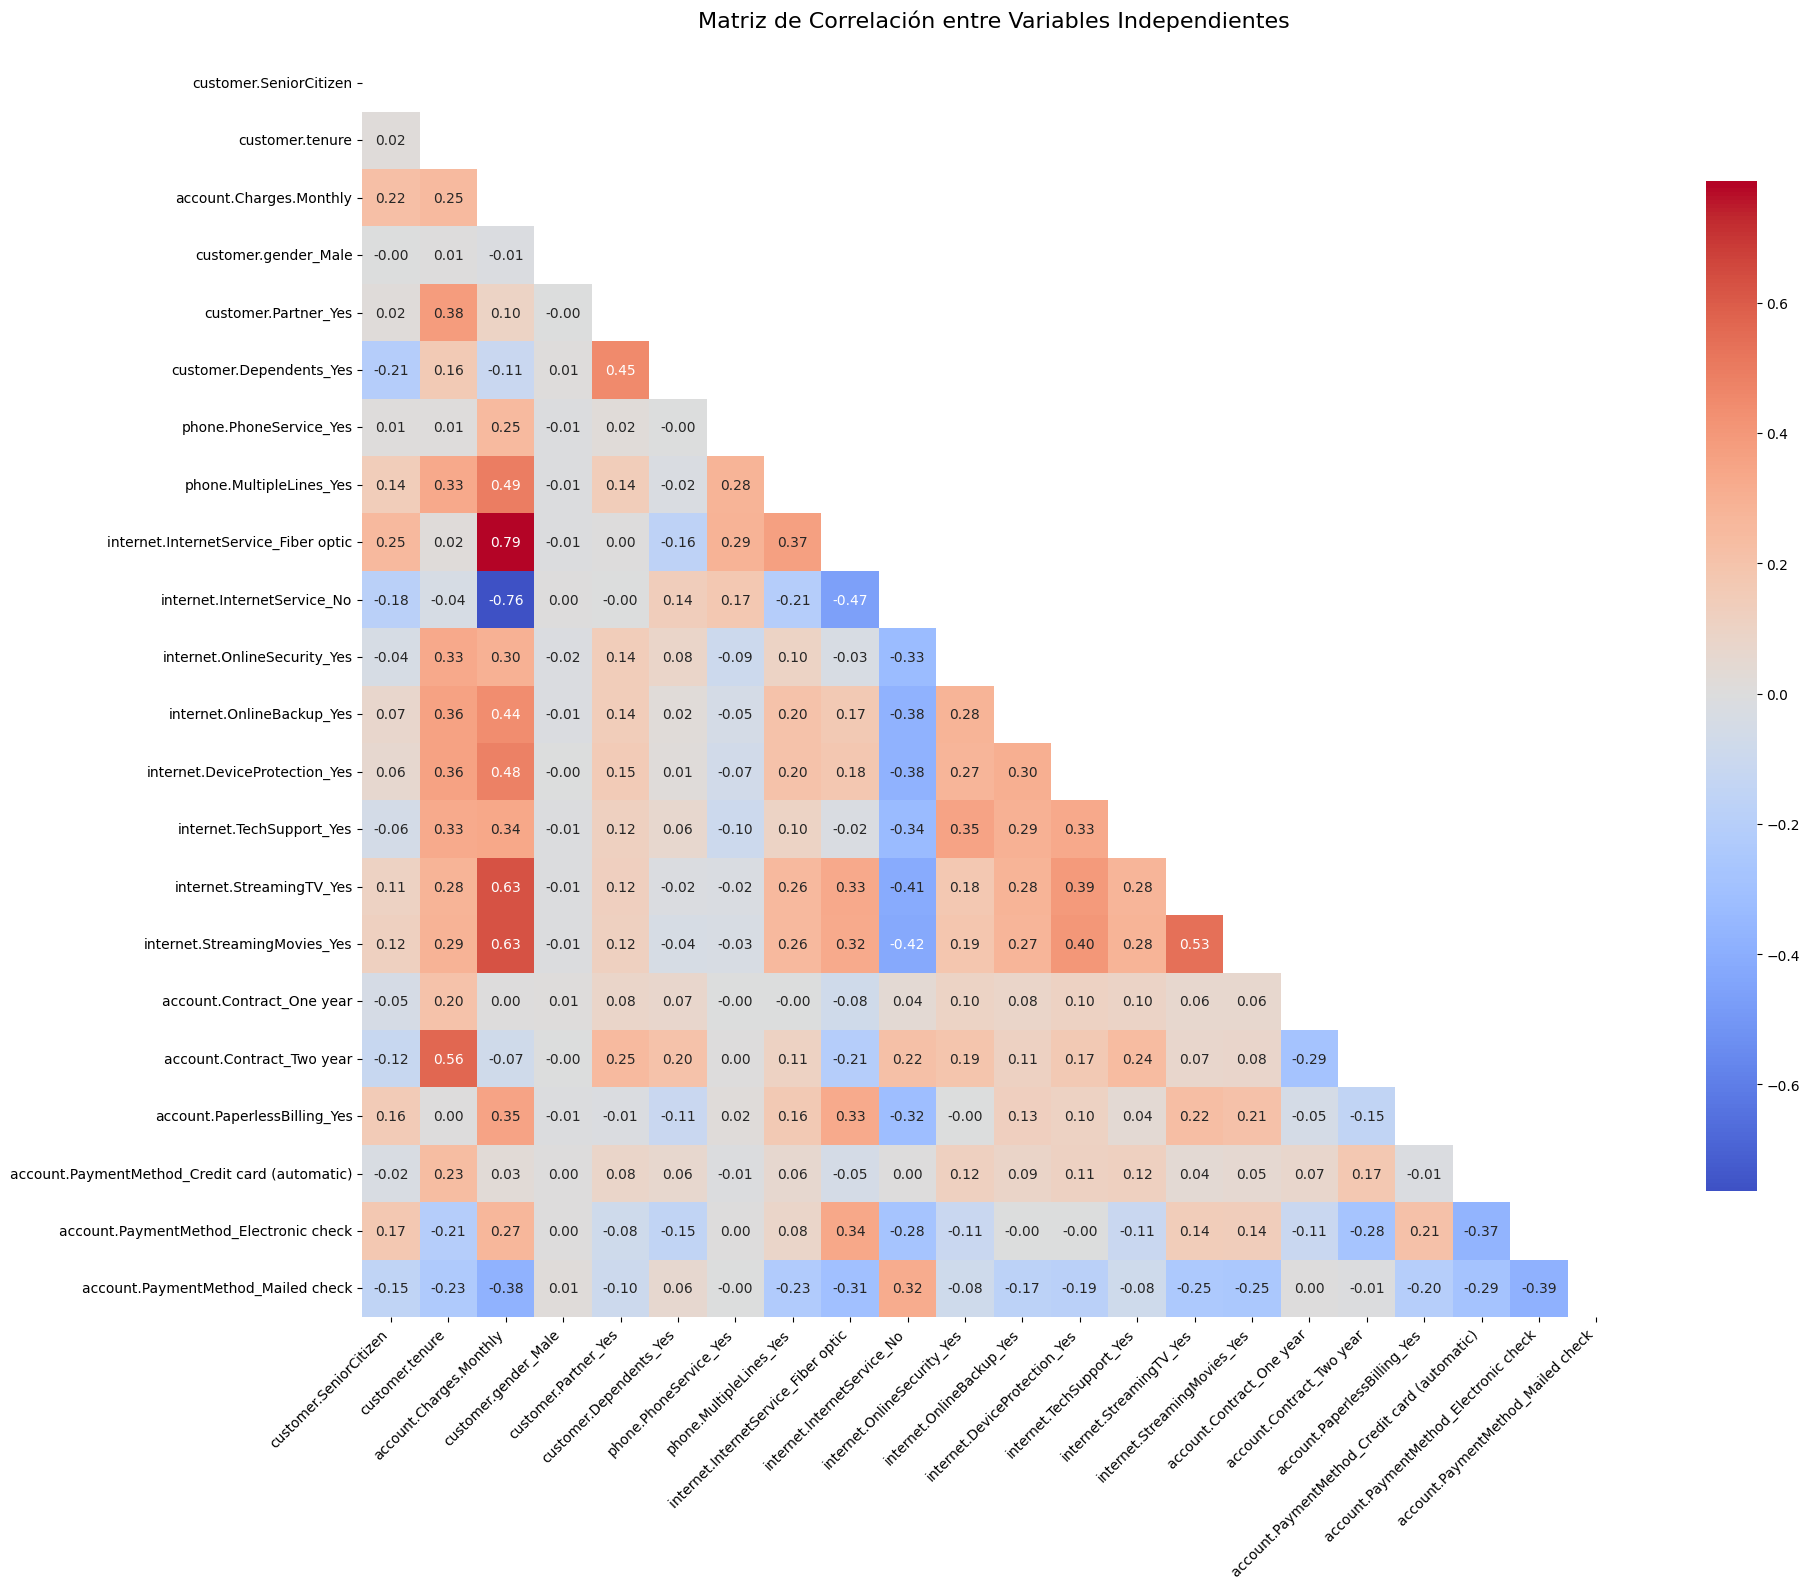


🔍 CORRELACIONES ALTAS (>0.7):
account.Charges.Monthly ↔ internet.InternetService_Fiber optic: 0.787
account.Charges.Monthly ↔ internet.InternetService_No: -0.763

📊 FACTOR DE INFLACIÓN DE VARIANZA (VIF):
Interpretación:
• VIF = 1: No correlación con otras variables
• VIF = 1-5: Correlación moderada
• VIF = 5-10: Correlación alta
• VIF > 10: Multicolinealidad problemática
--------------------------------------------------
account.Charges.Monthly                  VIF: 13.28 (🚨 PROBLEMÁTICA)
phone.PhoneService_Yes                   VIF: 10.14 (🚨 PROBLEMÁTICA)
internet.InternetService_Fiber optic     VIF: 7.44 (⚠️  ALTA)
internet.InternetService_No              VIF: 6.59 (⚠️  ALTA)
account.Contract_Two year                VIF: 3.46 (✅ MODERADA)
internet.StreamingTV_Yes                 VIF: 3.05 (✅ MODERADA)
internet.StreamingMovies_Yes             VIF: 3.02 (✅ MODERADA)
account.PaymentMethod_Electronic check   VIF: 2.97 (✅ MODERADA)
account.PaperlessBilling_Yes             VIF: 2.97 (✅ MO

In [109]:
# Verificación de Multicolinealidad - Proyecto Churn Telecomunicaciones

# ====================================
# MÉTODO 1: MATRIZ DE CORRELACIÓN
# ====================================

def matriz_correlacion_variables_independientes(df):
    """
    Crea matriz de correlación entre variables independientes
    """
    # Excluir la variable objetivo
    variables_independientes = df

    # Calcular matriz de correlación
    correlation_matrix = variables_independientes.corr()

    # Crear heatmap
    plt.figure(figsize=(20, 16))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Ocultar triángulo superior

    sns.heatmap(correlation_matrix,
                annot=True,
                cmap='coolwarm',
                center=0,
                square=True,
                fmt='.2f',
                cbar_kws={"shrink": .8},
                mask=mask)

    plt.title('Matriz de Correlación entre Variables Independientes', fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('matrix_corr.png')
    plt.show()

    return correlation_matrix

# ====================================
# MÉTODO 2: IDENTIFICAR CORRELACIONES ALTAS
# ====================================

def encontrar_correlaciones_altas(correlation_matrix, umbral=0.7):
    """
    Encuentra pares de variables con correlación alta
    """
    print(f"\n🔍 CORRELACIONES ALTAS (>{umbral}):")
    print("="*50)

    correlaciones_altas = []

    # Iterar sobre la matriz triangular superior
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_value = correlation_matrix.iloc[i, j]
            if abs(corr_value) > umbral:
                var1 = correlation_matrix.columns[i]
                var2 = correlation_matrix.columns[j]
                correlaciones_altas.append({
                    'Variable 1': var1,
                    'Variable 2': var2,
                    'Correlación': corr_value
                })
                print(f"{var1} ↔ {var2}: {corr_value:.3f}")

    if not correlaciones_altas:
        print("✅ No se encontraron correlaciones altas entre variables independientes")

    return correlaciones_altas

# ====================================
# MÉTODO 3: FACTOR DE INFLACIÓN DE VARIANZA (VIF)
# Se utilizan los datos escalados porque:
# * VIF es sensible a la escala de las variables
# * Variables con rangos muy diferentes pueden dar VIF artificialmente altos
# * El escalado mejora la estabilidad numérica del cálculo
# ====================================

def calcular_vif(df_scaler):
    """
    Calcula el Factor de Inflación de Varianza para cada variable
    """
    print("\n📊 FACTOR DE INFLACIÓN DE VARIANZA (VIF):")
    print("="*50)
    print("Interpretación:")
    print("• VIF = 1: No correlación con otras variables")
    print("• VIF = 1-5: Correlación moderada")
    print("• VIF = 5-10: Correlación alta")
    print("• VIF > 10: Multicolinealidad problemática")
    print("-"*50)

    # Preparar datos
    variables_independientes = df_scaler

    # Calcular VIF
    vif_data = []
    for i in range(df.shape[1]):
        vif_value = variance_inflation_factor(df_scaler.values, i)
        vif_data.append({
            'Variable': df_scaler.columns[i],
            'VIF': vif_value
        })

    # Crear DataFrame y ordenar por VIF
    vif_df = pd.DataFrame(vif_data)
    vif_df = vif_df.sort_values('VIF', ascending=False).reset_index(drop=True)

    # Mostrar resultados
    for idx, row in vif_df.iterrows():
        vif_val = row['VIF']
        if vif_val > 10:
            status = "🚨 PROBLEMÁTICA"
        elif vif_val > 5:
            status = "⚠️  ALTA"
        elif vif_val > 1:
            status = "✅ MODERADA"
        else:
            status = "✅ BAJA"

        print(f"{row['Variable']:<40} VIF: {vif_val:.2f} ({status})")

    return vif_df

# ====================================
# MÉTODO 4: RECOMENDACIONES PARA ELIMINAR VARIABLES
# ====================================

def recomendar_eliminacion_variables(vif_df, correlaciones_altas, umbral_vif=10):
    """
    Recomienda qué variables eliminar basado en VIF y correlaciones
    """
    print(f"\n💡 RECOMENDACIONES PARA ELIMINAR MULTICOLINEALIDAD:")
    print("="*60)

    variables_problematicas = vif_df[vif_df['VIF'] > umbral_vif]['Variable'].tolist()

    if variables_problematicas:
        print(f"Variables con VIF > {umbral_vif}:")
        for var in variables_problematicas:
            print(f"• {var}")

    if correlaciones_altas:
        print(f"\nPares de variables altamente correlacionadas:")
        for pair in correlaciones_altas:
            print(f"• {pair['Variable 1']} ↔ {pair['Variable 2']} (r={pair['Correlación']:.3f})")

    if not variables_problematicas and not correlaciones_altas:
        print("✅ No se detectaron problemas severos de multicolinealidad")
        print("   Puedes proceder con todas las variables al modelado")
    else:
        print(f"\n🎯 ESTRATEGIAS RECOMENDADAS:")
        print("1. Eliminar una variable de cada par altamente correlacionado")
        print("2. Mantener la variable con mayor correlación con Churn")
        print("3. Considerar PCA si hay muchas variables correlacionadas")
        print("4. Usar regularización (Lasso) que elimina variables automáticamente")

# ====================================
# FUNCIÓN PRINCIPAL PARA EJECUTAR TODO
# ====================================

def analizar_multicolinealidad_completo(df, df_scaler, umbral_corr=0.7, umbral_vif=10):
    """
    Ejecuta análisis completo de multicolinealidad
    """
    print("🔍 ANÁLISIS COMPLETO DE MULTICOLINEALIDAD")
    print("="*60)
    print(f"Variables independientes: {df.shape[1]}")

    # 1. Matriz de correlación
    correlation_matrix = matriz_correlacion_variables_independientes(df)

    # 2. Encontrar correlaciones altas
    correlaciones_altas = encontrar_correlaciones_altas(correlation_matrix, umbral_corr)

    # 3. Calcular VIF
    vif_df = calcular_vif(df_scaler)

    # 4. Recomendaciones
    recomendar_eliminacion_variables(vif_df, correlaciones_altas, umbral_vif)

    return {
        'correlation_matrix': correlation_matrix,
        'correlaciones_altas': correlaciones_altas,
        'vif_df': vif_df
    }

# ====================================
# EJEMPLO DE USO
# ====================================

# Ejecutar análisis completo
resultados = analizar_multicolinealidad_completo(X_processed_df, X_processed_scaler_df)

# Para análisis individual:
# correlation_matrix = matriz_correlacion_variables_independientes(df)
# vif_df = calcular_vif(df)



In [110]:
# SOLUCIÓN PRÁCTICA PARA TU MULTICOLINEALIDAD

def analizar_antes_eliminar(X_df, y_series):
    """
    Analiza las variables problemáticas antes de eliminar
    """
    print("🔍 ANÁLISIS PRE-ELIMINACIÓN")
    print("="*50)

    # Variables problemáticas
    problematicas = [
        'account.Charges.Monthly',
        'phone.PhoneService_Yes',
        'internet.InternetService_Fiber optic',
        'internet.InternetService_No'
    ]

    print("Correlaciones con Churn:")
    for var in problematicas:
        if var in X_df.columns:
            corr = X_df[var].corr(pd.Series(y_series))
            print(f"  {var:<40}: {corr:.3f}")

    print(f"\nCorrelaciones entre variables problemáticas:")
    subset = X_df[problematicas]
    corr_matrix = subset.corr()

    # Mostrar correlaciones altas
    for i in range(len(problematicas)):
        for j in range(i+1, len(problematicas)):
            var1, var2 = problematicas[i], problematicas[j]
            if var1 in corr_matrix.columns and var2 in corr_matrix.columns:
                corr_val = corr_matrix.loc[var1, var2]
                if abs(corr_val) > 0.7:
                    print(f"  {var1} ↔ {var2}: {corr_val:.3f} 🚨")

def estrategia_eliminacion_inteligente(X_df, y_series):
    """
    Estrategia inteligente para eliminar variables
    """
    print(f"\n🎯 ESTRATEGIA DE ELIMINACIÓN INTELIGENTE")
    print("="*55)

    variables_eliminar = []

    # DECISIÓN 1: phone.PhoneService_Yes
    phone_corr = abs(X_df['phone.PhoneService_Yes'].corr(pd.Series(y_series)))
    print(f"1. phone.PhoneService_Yes:")
    print(f"   • VIF: 10.14 (problemático)")
    print(f"   • Correlación con Churn: {phone_corr:.3f}")

    if phone_corr < 0.1:  # Muy baja correlación
        print(f"   ❌ ELIMINAR: VIF alto + baja correlación con Churn")
        variables_eliminar.append('phone.PhoneService_Yes')
    else:
        print(f"   ⚠️  CONSIDERAR: VIF alto pero correlación significativa")

    # DECISIÓN 2: Conflicto Monthly Charges vs Internet Service
    monthly_corr = abs(X_df['account.Charges.Monthly'].corr(pd.Series(y_series)))
    fiber_corr = abs(X_df['internet.InternetService_Fiber optic'].corr(pd.Series(y_series)))
    no_internet_corr = abs(X_df['internet.InternetService_No'].corr(pd.Series(y_series)))

    print(f"\n2. Conflicto: Monthly Charges vs Internet Service types")
    print(f"   • Monthly Charges → Churn: {monthly_corr:.3f}")
    print(f"   • Fiber Optic → Churn: {fiber_corr:.3f}")
    print(f"   • No Internet → Churn: {no_internet_corr:.3f}")

    # Lógica de decisión
    if monthly_corr > max(fiber_corr, no_internet_corr):
        print(f"   ✅ MANTENER: account.Charges.Monthly (mayor predictor)")
        print(f"   ❌ ELIMINAR: internet.InternetService_Fiber optic")
        variables_eliminar.append('internet.InternetService_Fiber optic')
    else:
        print(f"   ✅ MANTENER: Variables de Internet Service")
        print(f"   ❌ ELIMINAR: account.Charges.Monthly")
        variables_eliminar.append('account.Charges.Monthly')

    return variables_eliminar

def aplicar_eliminacion(X_scaler_df, variables_eliminar):
    """
    Aplica la eliminación de variables
    """
    print(f"\n🧹 APLICANDO ELIMINACIÓN")
    print("="*35)

    X_limpio = X_scaler_df.copy()

    print(f"Variables a eliminar:")
    for var in variables_eliminar:
        if var in X_limpio.columns:
            X_limpio = X_limpio.drop(columns=[var])
            print(f"  ❌ {var}")
        else:
            print(f"  ⚠️  {var} (no encontrada)")

    print(f"\nResumen:")
    print(f"  • Original: {X_scaler_df.shape[1]} variables")
    print(f"  • Eliminadas: {len([v for v in variables_eliminar if v in X_scaler_df.columns])}")
    print(f"  • Final: {X_limpio.shape[1]} variables")

    return X_limpio

def verificar_mejora_vif(X_limpio):
    """
    Verifica si mejoró el VIF después de eliminar variables
    """

    print(f"\n📊 VERIFICACIÓN POST-ELIMINACIÓN")
    print("="*40)

    # Variables que podrían seguir siendo problemáticas
    verificar_vars = [
        'account.Charges.Monthly',
        'phone.PhoneService_Yes',
        'internet.InternetService_Fiber optic',
        'internet.InternetService_No'
    ]

    print("VIF después de eliminación:")
    vifs_altos = []

    for var in verificar_vars:
        if var in X_limpio.columns:
            idx = X_limpio.columns.get_loc(var)
            vif = variance_inflation_factor(X_limpio, idx)

            if vif > 10:
                status = "🚨 AÚN PROBLEMÁTICA"
                vifs_altos.append(var)
            elif vif > 5:
                status = "⚠️  ALTA PERO ACEPTABLE"
            else:
                status = "✅ MEJORADA"

            print(f"  {var:<35}: {vif:.2f} ({status})")

    if vifs_altos:
        print(f"\n⚠️  Variables aún problemáticas: {vifs_altos}")
        print("Considera eliminar una más o usar regularización.")
    else:
        print(f"\n✅ ¡Multicolinealidad solucionada!")

def solucion_completa_tu_caso(X_df, X_scaler_df, y_series):
    """
    Solución completa para tu caso específico
    """
    print("🚀 SOLUCIÓN COMPLETA PARA TU PROYECTO CHURN")
    print("="*60)

    # 1. Análisis inicial
    analizar_antes_eliminar(X_df, y_series)

    # 2. Decidir qué eliminar
    variables_eliminar = estrategia_eliminacion_inteligente(X_df, y_series)

    # 3. Aplicar eliminación
    X_limpio = aplicar_eliminacion(X_scaler_df, variables_eliminar)

    # 4. Verificar mejora
    verificar_mejora_vif(X_limpio)

    # 5. Recomendaciones finales
    print(f"\n💡 PRÓXIMOS PASOS:")
    print("="*25)
    print("1. ✅ Usar X_limpio para dividir train/test/validation")
    print("2. 🔄 Re-aplicar scaling solo a X_limpio")
    print("3. 🎯 Entrenar modelos (Logistic Regression + Random Forest)")
    print("4. 📊 Comparar performance con/sin variables eliminadas")

    return X_limpio, variables_eliminar

# VERSIÓN RÁPIDA - SI TIENES PRISA
def solucion_rapida(X_df):
    """
    Solución rápida basada en tus resultados
    """
    print("⚡ SOLUCIÓN RÁPIDA")
    print("="*25)

    # Basado en tus resultados, eliminar estas variables:
    eliminar = [
        'phone.PhoneService_Yes',  # VIF muy alto
        'internet.InternetService_Fiber optic'  # Alta correlación con Monthly Charges
    ]

    X_limpio = X_df.drop(columns=eliminar, errors='ignore')

    print(f"Variables eliminadas:")
    for var in eliminar:
        print(f"  ❌ {var}")

    print(f"\nDataset: {X_df.shape[1]} → {X_limpio.shape[1]} variables")

    return X_limpio

print("🎯 OPCIONES PARA EJECUTAR:")
print("="*30)
print("COMPLETA: X_limpio, eliminadas = solucion_completa_tu_caso(X_processed_df, y_train)")
print("RÁPIDA:   X_limpio = solucion_rapida(X_processed_df)")
solucion_completa_tu_caso(X_processed_df, X_processed_scaler_df, y)

# Calcular correlación con target
# problematicas = [
#         'account.Charges.Monthly',
#         'phone.PhoneService_Yes',
#         'internet.InternetService_Fiber optic',
#         'internet.InternetService_No'
#     ]
# X_processed_df['phone.PhoneService_Yes'].corr(pd.Series(y, index=X_processed_df.index))

🎯 OPCIONES PARA EJECUTAR:
COMPLETA: X_limpio, eliminadas = solucion_completa_tu_caso(X_processed_df, y_train)
RÁPIDA:   X_limpio = solucion_rapida(X_processed_df)
🚀 SOLUCIÓN COMPLETA PARA TU PROYECTO CHURN
🔍 ANÁLISIS PRE-ELIMINACIÓN
Correlaciones con Churn:
  account.Charges.Monthly                 : 0.193
  phone.PhoneService_Yes                  : 0.012
  internet.InternetService_Fiber optic    : 0.307
  internet.InternetService_No             : -0.228

Correlaciones entre variables problemáticas:
  account.Charges.Monthly ↔ internet.InternetService_Fiber optic: 0.787 🚨
  account.Charges.Monthly ↔ internet.InternetService_No: -0.763 🚨

🎯 ESTRATEGIA DE ELIMINACIÓN INTELIGENTE
1. phone.PhoneService_Yes:
   • VIF: 10.14 (problemático)
   • Correlación con Churn: 0.012
   ❌ ELIMINAR: VIF alto + baja correlación con Churn

2. Conflicto: Monthly Charges vs Internet Service types
   • Monthly Charges → Churn: 0.193
   • Fiber Optic → Churn: 0.307
   • No Internet → Churn: 0.228
   ✅ MANTENE

(      customer.SeniorCitizen  customer.tenure  customer.gender_Male  \
 0                  -0.440327        -0.954296                   0.0   
 1                  -0.440327        -0.954296                   1.0   
 2                  -0.440327        -1.158016                   1.0   
 3                   2.271039        -0.791321                   1.0   
 4                   2.271039        -1.198760                   0.0   
 ...                      ...              ...                   ...   
 7027               -0.440327        -0.791321                   0.0   
 7028               -0.440327        -0.424625                   1.0   
 7029               -0.440327        -1.239504                   1.0   
 7030               -0.440327         1.408853                   1.0   
 7031               -0.440327         1.245878                   1.0   
 
       customer.Partner_Yes  customer.Dependents_Yes  phone.MultipleLines_Yes  \
 0                      1.0                      1.0 

De acuerdo al análisis de la multicolinealidad, hay problemas con las varaibles `'account.Charges.Monthly'`, `'phone.PhoneService_Yes'`, `'internet.InternetService_Fiber optic'`, y `'internetInternetService_No'`.

Haciendo un análisis de correlación con la varaible de interés `Churn`, se decide eliminar `'phone.PhoneService_Yes'` y `'account.Charges.Monthly'`.





####  Nueva divisón train, test, validation variables numericas no escaladas

In [111]:
# variables a eliminar
variables_eliminar_multicolinealidad = ['phone.PhoneService_Yes', 'account.Charges.Monthly']

X_processed_df = X_processed_df.drop(columns=variables_eliminar_multicolinealidad)
X_processed_scaler_df = X_processed_scaler_df.drop(columns=variables_eliminar_multicolinealidad)


In [112]:

# División estratificada para mantener proporción de churn
X_trainTest, X_validation, y_trainTest, y_validation = train_test_split(
    X_processed_df, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train, X_test, y_train, y_test = train_test_split(
    X_trainTest, y_trainTest,
    test_size=0.25,
    random_state=42,
    stratify=y_trainTest
)

print(f"División completada:")
print(f"   • Train: {X_train.shape[0]} registros ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   • Test:  {X_test.shape[0]} registros ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"   • Validation:  {X_validation.shape[0]} registros ({X_validation.shape[0]/len(X)*100:.1f}%)")
print(f"   • Features: {X_train.shape[1]} variables")

# Verificar distribución de churn en train/test
train_churn_rate = y_train.mean() * 100
test_churn_rate = y_test.mean() * 100
validation_churn_rate = y_validation.mean() * 100
original_churn_rate = y.mean() * 100
print(f"   • Churn rate train: {train_churn_rate:.1f}%")
print(f"   • Churn rate test:  {test_churn_rate:.1f}%")
print(f"   • Churn rate validation:  {validation_churn_rate:.1f}%")
print(f"   • Original Churn rate :  {original_churn_rate:.1f}%")

# Verificar que las proporciones están balanceadas
max_diff = max(abs(train_churn_rate - original_churn_rate),
               abs(test_churn_rate - original_churn_rate),
               abs(validation_churn_rate - original_churn_rate))

if max_diff < 2:  # Diferencia menor a 2%
    print(f"✅ Estratificación exitosa - diferencias < 2%")
else:
    print(f"⚠️  Revisar estratificación - diferencia máxima: {max_diff:.1f}%")

División completada:
   • Train: 4218 registros (60.0%)
   • Test:  1407 registros (20.0%)
   • Validation:  1407 registros (20.0%)
   • Features: 20 variables
   • Churn rate train: 26.6%
   • Churn rate test:  26.6%
   • Churn rate validation:  26.6%
   • Original Churn rate :  26.6%
✅ Estratificación exitosa - diferencias < 2%


#### Nueva divisón train, test, validation variables numericas escaladas

In [113]:
# División estratificada para mantener proporción de churn
X_trainTest_scaler, X_validation_scaler, y_trainTest_scaler, y_validation_scaler = train_test_split(
    X_processed_scaler_df, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train_scaler, X_test_scaler, y_train_scaler, y_test_scaler = train_test_split(
    X_trainTest_scaler, y_trainTest_scaler,
    test_size=0.25,
    random_state=42,
    stratify=y_trainTest_scaler
)

print(f"División completada:")
print(f"   • Train: {X_train_scaler.shape[0]} registros ({X_train_scaler.shape[0]/len(X)*100:.1f}%)")
print(f"   • Test:  {X_test_scaler.shape[0]} registros ({X_test_scaler.shape[0]/len(X)*100:.1f}%)")
print(f"   • Validation:  {X_validation_scaler.shape[0]} registros ({X_validation_scaler.shape[0]/len(X)*100:.1f}%)")
print(f"   • Features: {X_train_scaler.shape[1]} variables")

# Verificar distribución de churn en train/test
train_scaler_churn_rate = y_train_scaler.mean() * 100
test_scaler_churn_rate = y_test_scaler.mean() * 100
validation_scaler_churn_rate = y_validation_scaler.mean() * 100
original_scaler_churn_rate = y.mean() * 100
print(f"   • Churn rate train scaler: {train_scaler_churn_rate:.1f}%")
print(f"   • Churn rate test scaler:  {test_scaler_churn_rate:.1f}%")
print(f"   • Churn rate validation scaler:  {validation_scaler_churn_rate:.1f}%")
print(f"   • Original Churn rate scaler :  {original_scaler_churn_rate:.1f}%")

# Verificar que las proporciones están balanceadas
max_diff = max(abs(train_scaler_churn_rate - original_scaler_churn_rate),
               abs(test_scaler_churn_rate - original_scaler_churn_rate),
               abs(validation_scaler_churn_rate - original_scaler_churn_rate))

if max_diff < 2:  # Diferencia menor a 2%
    print(f"✅ Estratificación exitosa - diferencias < 2%")
else:
    print(f"⚠️  Revisar estratificación - diferencia máxima: {max_diff:.1f}%")

División completada:
   • Train: 4218 registros (60.0%)
   • Test:  1407 registros (20.0%)
   • Validation:  1407 registros (20.0%)
   • Features: 20 variables
   • Churn rate train scaler: 26.6%
   • Churn rate test scaler:  26.6%
   • Churn rate validation scaler:  26.6%
   • Original Churn rate scaler :  26.6%
✅ Estratificación exitosa - diferencias < 2%


## 🤖 Modelos Predictivos

### Regresión logística

🎯 REGRESIÓN LOGÍSTICA COMPLETA - PROYECTO CHURN
🚀 ENTRENAMIENTO REGRESIÓN LOGÍSTICA
📊 Datos de entrenamiento:
  • X_train: (4218, 20)
  • y_train: 4218 (distribución: [3097 1121])
✅ Modelo entrenado exitosamente

🎯 GENERANDO PREDICCIONES
✅ Predicciones generadas para todos los conjuntos

📊 MÉTRICAS DE EVALUACIÓN COMPARATIVAS
                      train   test validation
Accuracy              0.755  0.748      0.749
Precision             0.526  0.518      0.519
Recall (Sensitivity)  0.800  0.765      0.786
F1-Score              0.635  0.618      0.625
ROC-AUC               0.851  0.828      0.840
Avg Precision         0.660  0.613      0.640
Specificity           0.739  0.742      0.736

💡 INTERPRETACIÓN:
📈 Rendimiento en Test (conjunto más importante):
  • Accuracy: 74.8% - % de predicciones correctas
  • Precision: 51.8% - De los que predijo Churn, % correctos
  • Recall: 76.5% - De los que realmente se van, % detectados
  • F1-Score: 0.618 - Balance entre Precision y Recall
  • ROC-A

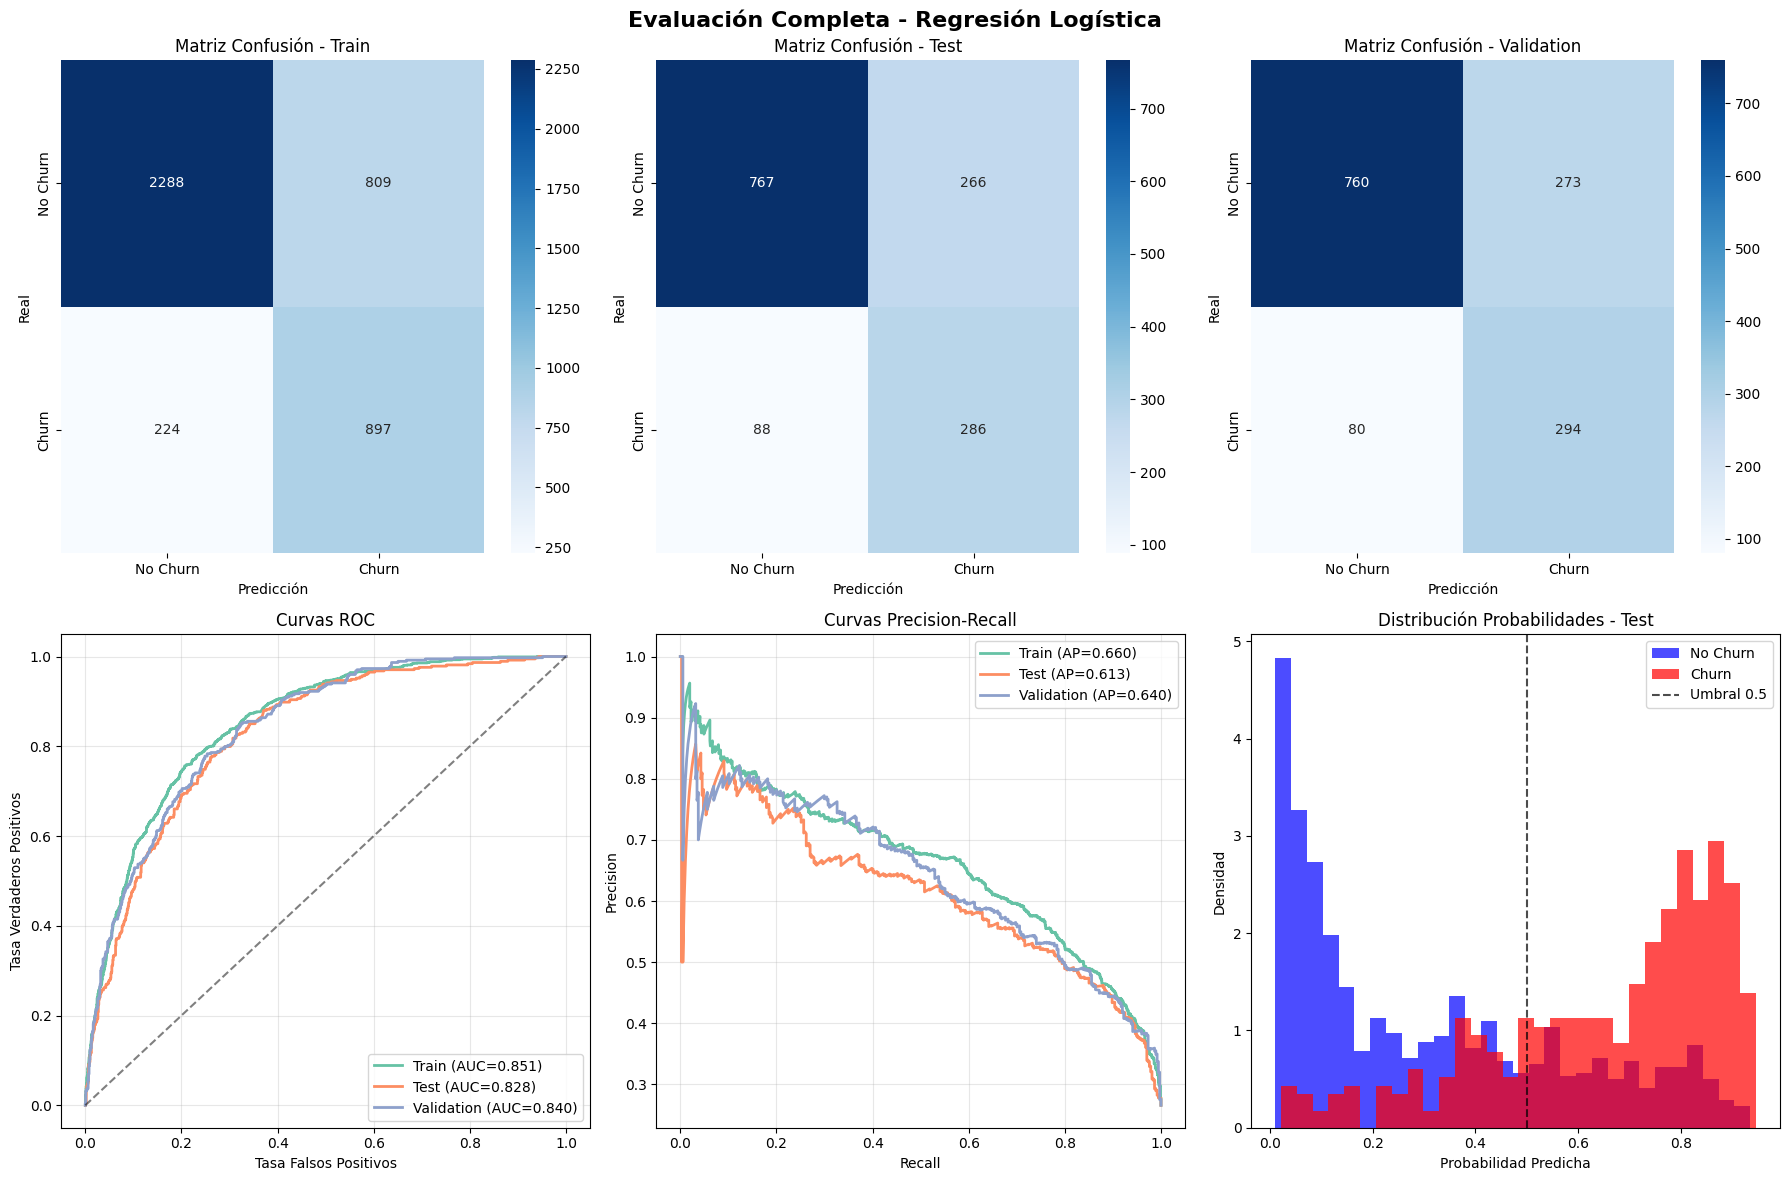


🔍 IMPORTANCIA DE VARIABLES
🏆 TOP 15 VARIABLES MÁS IMPORTANTES:
------------------------------------------------------------
 1. account.Contract_Two year           | Coef: -1.411 | 📉 Reduce Churn
 2. internet.InternetService_No         | Coef: -0.889 | 📉 Reduce Churn
 3. customer.tenure                     | Coef: -0.809 | 📉 Reduce Churn
 4. internet.InternetService_Fiber optic | Coef: +0.774 | 📈 Aumenta Churn
 5. account.Contract_One year           | Coef: -0.734 | 📉 Reduce Churn
 6. account.PaymentMethod_Electronic check | Coef: +0.518 | 📈 Aumenta Churn
 7. internet.TechSupport_Yes            | Coef: -0.363 | 📉 Reduce Churn
 8. internet.StreamingTV_Yes            | Coef: +0.352 | 📈 Aumenta Churn
 9. internet.StreamingMovies_Yes        | Coef: +0.297 | 📈 Aumenta Churn
10. account.PaperlessBilling_Yes        | Coef: +0.246 | 📈 Aumenta Churn
11. internet.OnlineSecurity_Yes         | Coef: -0.211 | 📉 Reduce Churn
12. phone.MultipleLines_Yes             | Coef: +0.160 | 📈 Aumenta Churn
1

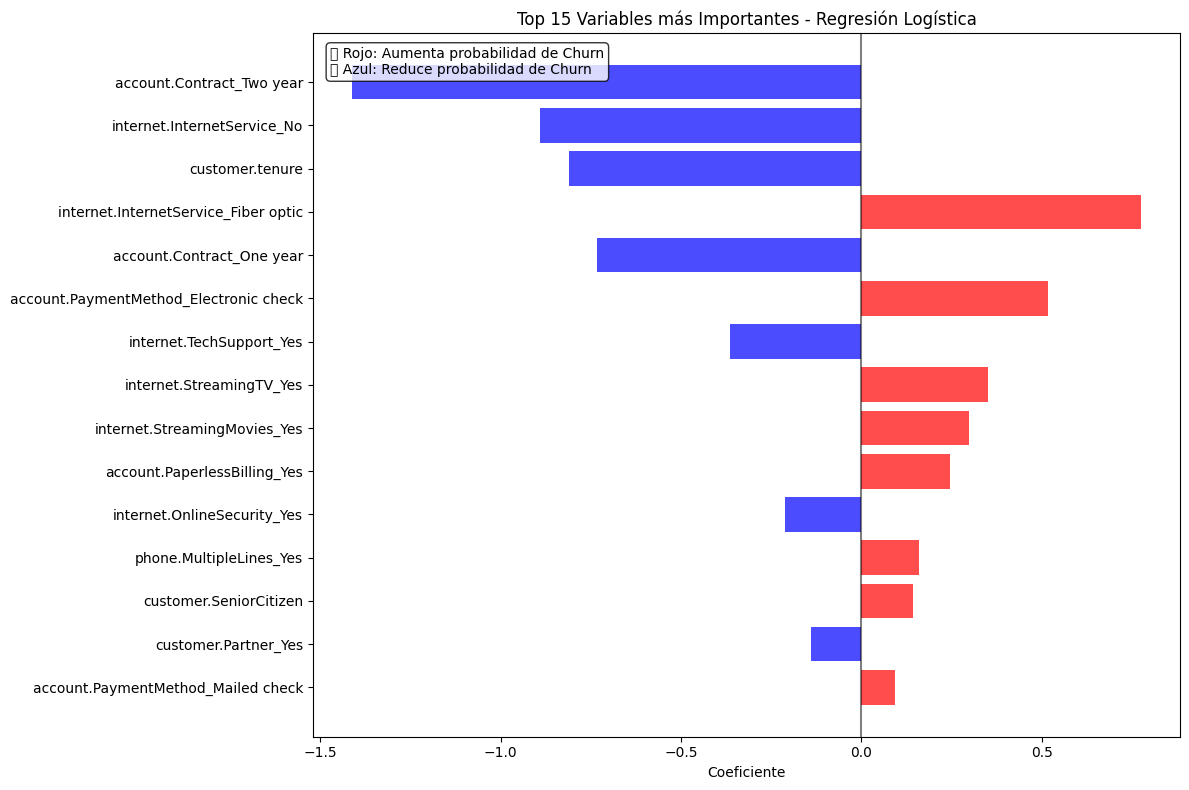


📋 REPORTE FINAL:
✅ Modelo entrenado con class_weight='balanced'
📊 Performance en Test:
   • ROC-AUC: 0.828 (Excelente)
   • F1-Score: 0.618
   • Recall: 0.765 (% de churns detectados)


{'modelo': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
 'resultados': {'train': {'y_true': array([0, 0, 0, ..., 0, 0, 0]),
   'y_pred': array([0, 0, 0, ..., 0, 1, 0]),
   'y_proba': array([0.17760303, 0.17919214, 0.03198812, ..., 0.39851151, 0.77560482,
          0.40875345])},
  'test': {'y_true': array([0, 0, 1, ..., 1, 0, 0]),
   'y_pred': array([1, 0, 1, ..., 0, 0, 0]),
   'y_proba': array([0.80712352, 0.11192487, 0.8214786 , ..., 0.15356988, 0.01286015,
          0.0108452 ])},
  'validation': {'y_true': array([0, 0, 0, ..., 0, 0, 0]),
   'y_pred': array([0, 1, 0, ..., 1, 0, 1]),
   'y_proba': array([0.16317895, 0.76388137, 0.02035292, ..., 0.6279902 , 0.02260004,
          0.53226017])}},
 'metricas': {'train': {'accuracy': 0.7550972024656235,
   'precision': 0.5257913247362251,
   'recall': 0.800178412132025,
   'f1_score': 0.6345949770074284,
   'roc_auc': np.float64(0.8506594825587307),
   'avg_precision': np.float64(0.6603521717220946),
   'co

In [114]:
# ====================================
# FUNCIÓN PRINCIPAL DE ENTRENAMIENTO
# ====================================

def entrenar_regresion_logistica(X_train, X_test, X_val, y_train, y_test, y_val):
    """
    Entrena modelo de regresión logística con class_weight='balanced'
    """
    print("🚀 ENTRENAMIENTO REGRESIÓN LOGÍSTICA")
    print("="*60)

    # Crear y entrenar modelo
    modelo_lr = LogisticRegression(
        class_weight='balanced',    # ¡Muy importante para datos desbalanceados!
        random_state=42,
        max_iter=1000              # Suficientes iteraciones
    )

    print(f"📊 Datos de entrenamiento:")
    print(f"  • X_train: {X_train.shape}")
    print(f"  • y_train: {len(y_train)} (distribución: {np.bincount(y_train)})")

    # Entrenar modelo
    modelo_lr.fit(X_train, y_train)

    print(f"✅ Modelo entrenado exitosamente")

    return modelo_lr

# ====================================
# PREDICCIONES EN TODOS LOS CONJUNTOS
# ====================================

def generar_predicciones(modelo, X_train, X_test, X_val, y_train, y_test, y_val):
    """
    Genera predicciones para todos los conjuntos de datos
    """
    print(f"\n🎯 GENERANDO PREDICCIONES")
    print("="*35)

    resultados = {}

    # Predicciones en conjunto de entrenamiento
    y_train_pred = modelo.predict(X_train)
    y_train_proba = modelo.predict_proba(X_train)[:, 1]
    resultados['train'] = {
        'y_true': y_train,
        'y_pred': y_train_pred,
        'y_proba': y_train_proba
    }

    # Predicciones en conjunto de prueba
    y_test_pred = modelo.predict(X_test)
    y_test_proba = modelo.predict_proba(X_test)[:, 1]
    resultados['test'] = {
        'y_true': y_test,
        'y_pred': y_test_pred,
        'y_proba': y_test_proba
    }

    # Predicciones en conjunto de validación
    y_val_pred = modelo.predict(X_val)
    y_val_proba = modelo.predict_proba(X_val)[:, 1]
    resultados['validation'] = {
        'y_true': y_val,
        'y_pred': y_val_pred,
        'y_proba': y_val_proba
    }

    print(f"✅ Predicciones generadas para todos los conjuntos")

    return resultados

# ====================================
# MÉTRICAS DE EVALUACIÓN COMPLETAS
# ====================================

def calcular_metricas_completas(y_true, y_pred, y_proba, conjunto_nombre=""):
    """
    Calcula todas las métricas de evaluación
    """
    metricas = {}

    # Métricas básicas
    metricas['accuracy'] = accuracy_score(y_true, y_pred)
    metricas['precision'] = precision_score(y_true, y_pred)
    metricas['recall'] = recall_score(y_true, y_pred)
    metricas['f1_score'] = f1_score(y_true, y_pred)

    # Métricas de probabilidad
    metricas['roc_auc'] = roc_auc_score(y_true, y_proba)
    metricas['avg_precision'] = average_precision_score(y_true, y_proba)

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    metricas['confusion_matrix'] = cm

    # Especificidad (True Negative Rate)
    tn, fp, fn, tp = cm.ravel()
    metricas['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    metricas['sensitivity'] = tp / (tp + fn) if (tp + fn) > 0 else 0  # = recall

    return metricas

def mostrar_metricas_tabla(resultados_predicciones):
    """
    Muestra métricas en formato tabla comparativa
    """
    print(f"\n📊 MÉTRICAS DE EVALUACIÓN COMPARATIVAS")
    print("="*70)

    # Calcular métricas para cada conjunto
    metricas_todos = {}
    for conjunto, datos in resultados_predicciones.items():
        metricas_todos[conjunto] = calcular_metricas_completas(
            datos['y_true'], datos['y_pred'], datos['y_proba'], conjunto
        )

    # Crear tabla comparativa
    df_metricas = pd.DataFrame({
        conjunto: {
            'Accuracy': f"{metricas['accuracy']:.3f}",
            'Precision': f"{metricas['precision']:.3f}",
            'Recall (Sensitivity)': f"{metricas['recall']:.3f}",
            'F1-Score': f"{metricas['f1_score']:.3f}",
            'ROC-AUC': f"{metricas['roc_auc']:.3f}",
            'Avg Precision': f"{metricas['avg_precision']:.3f}",
            'Specificity': f"{metricas['specificity']:.3f}"
        }
        for conjunto, metricas in metricas_todos.items()
    })

    print(df_metricas)

    # Interpretación
    print(f"\n💡 INTERPRETACIÓN:")
    print("="*25)
    test_metrics = metricas_todos['test']
    print(f"📈 Rendimiento en Test (conjunto más importante):")
    print(f"  • Accuracy: {test_metrics['accuracy']:.1%} - % de predicciones correctas")
    print(f"  • Precision: {test_metrics['precision']:.1%} - De los que predijo Churn, % correctos")
    print(f"  • Recall: {test_metrics['recall']:.1%} - De los que realmente se van, % detectados")
    print(f"  • F1-Score: {test_metrics['f1_score']:.3f} - Balance entre Precision y Recall")
    print(f"  • ROC-AUC: {test_metrics['roc_auc']:.3f} - Capacidad discriminativa (0.5=azar, 1.0=perfecto)")

    return metricas_todos

# ====================================
# VISUALIZACIONES
# ====================================

def crear_visualizaciones(resultados_predicciones, metricas_todos):
    """
    Crea todas las visualizaciones importantes
    """
    print(f"\n📊 CREANDO VISUALIZACIONES")
    print("="*35)

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Evaluación Completa - Regresión Logística', fontsize=16, fontweight='bold')

    # 1. Matrices de Confusión
    for i, (conjunto, metricas) in enumerate(metricas_todos.items()):
        ax = axes[0, i]
        cm = metricas['confusion_matrix']

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=['No Churn', 'Churn'],
                   yticklabels=['No Churn', 'Churn'])
        ax.set_title(f'Matriz Confusión - {conjunto.title()}')
        ax.set_xlabel('Predicción')
        ax.set_ylabel('Real')

    # 2. Curvas ROC
    ax_roc = axes[1, 0]
    for conjunto, datos in resultados_predicciones.items():
        fpr, tpr, _ = roc_curve(datos['y_true'], datos['y_proba'])
        auc = roc_auc_score(datos['y_true'], datos['y_proba'])
        ax_roc.plot(fpr, tpr, label=f'{conjunto.title()} (AUC={auc:.3f})', linewidth=2)

    ax_roc.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    ax_roc.set_xlabel('Tasa Falsos Positivos')
    ax_roc.set_ylabel('Tasa Verdaderos Positivos')
    ax_roc.set_title('Curvas ROC')
    ax_roc.legend()
    ax_roc.grid(alpha=0.3)

    # 3. Curvas Precision-Recall
    ax_pr = axes[1, 1]
    for conjunto, datos in resultados_predicciones.items():
        precision, recall, _ = precision_recall_curve(datos['y_true'], datos['y_proba'])
        avg_precision = average_precision_score(datos['y_true'], datos['y_proba'])
        ax_pr.plot(recall, precision, label=f'{conjunto.title()} (AP={avg_precision:.3f})', linewidth=2)

    ax_pr.set_xlabel('Recall')
    ax_pr.set_ylabel('Precision')
    ax_pr.set_title('Curvas Precision-Recall')
    ax_pr.legend()
    ax_pr.grid(alpha=0.3)

    # 4. Distribución de Probabilidades
    ax_dist = axes[1, 2]
    test_data = resultados_predicciones['test']

    # Probabilidades para cada clase
    churn_probs = test_data['y_proba'][test_data['y_true'] == 1]
    no_churn_probs = test_data['y_proba'][test_data['y_true'] == 0]

    ax_dist.hist(no_churn_probs, bins=30, alpha=0.7, label='No Churn', color='blue', density=True)
    ax_dist.hist(churn_probs, bins=30, alpha=0.7, label='Churn', color='red', density=True)
    ax_dist.axvline(x=0.5, color='black', linestyle='--', alpha=0.7, label='Umbral 0.5')
    ax_dist.set_xlabel('Probabilidad Predicha')
    ax_dist.set_ylabel('Densidad')
    ax_dist.set_title('Distribución Probabilidades - Test')
    ax_dist.legend()

    plt.tight_layout()
    plt.show()

# ====================================
# IMPORTANCIA DE VARIABLES
# ====================================

def analizar_importancia_variables(modelo, X_columns, top_n=15):
    """
    Analiza la importancia de las variables en el modelo
    """
    print(f"\n🔍 IMPORTANCIA DE VARIABLES")
    print("="*40)

    # Obtener coeficientes
    coeficientes = modelo.coef_[0]

    # Crear DataFrame con variables e importancia
    importancia_df = pd.DataFrame({
        'Variable': X_columns,
        'Coeficiente': coeficientes,
        'Importancia_Abs': np.abs(coeficientes)
    })

    # Ordenar por importancia absoluta
    importancia_df = importancia_df.sort_values('Importancia_Abs', ascending=False)

    # Mostrar top variables
    print(f"🏆 TOP {top_n} VARIABLES MÁS IMPORTANTES:")
    print("-" * 60)

    for i, (_, row) in enumerate(importancia_df.head(top_n).iterrows(), 1):
        efecto = "📈 Aumenta Churn" if row['Coeficiente'] > 0 else "📉 Reduce Churn"
        print(f"{i:2d}. {row['Variable']:<35} | Coef: {row['Coeficiente']:+.3f} | {efecto}")

    # Visualización
    plt.figure(figsize=(12, 8))
    top_vars = importancia_df.head(top_n)

    colors = ['red' if coef > 0 else 'blue' for coef in top_vars['Coeficiente']]

    plt.barh(range(len(top_vars)), top_vars['Coeficiente'], color=colors, alpha=0.7)
    plt.yticks(range(len(top_vars)), top_vars['Variable'])
    plt.xlabel('Coeficiente')
    plt.title(f'Top {top_n} Variables más Importantes - Regresión Logística')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
    plt.gca().invert_yaxis()

    # Añadir leyenda
    plt.text(0.02, 0.98, '🔴 Rojo: Aumenta probabilidad de Churn\n🔵 Azul: Reduce probabilidad de Churn',
             transform=plt.gca().transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

    return importancia_df

# ====================================
# FUNCIÓN PRINCIPAL COMPLETA
# ====================================

def regresion_logistica_completa(X_train, X_test, X_val, y_train, y_test, y_val):
    """
    Pipeline completo de regresión logística
    """
    print("🎯 REGRESIÓN LOGÍSTICA COMPLETA - PROYECTO CHURN")
    print("="*70)

    # 1. Entrenar modelo
    modelo = entrenar_regresion_logistica(X_train, X_test, X_val, y_train, y_test, y_val)

    # 2. Generar predicciones
    resultados = generar_predicciones(modelo, X_train, X_test, X_val, y_train, y_test, y_val)

    # 3. Calcular métricas
    metricas = mostrar_metricas_tabla(resultados)

    # 4. Crear visualizaciones
    crear_visualizaciones(resultados, metricas)

    # 5. Analizar importancia
    importancia = analizar_importancia_variables(modelo, X_train.columns)

    # 6. Reporte final
    print(f"\n📋 REPORTE FINAL:")
    print("="*25)
    test_metrics = metricas['test']
    print(f"✅ Modelo entrenado con class_weight='balanced'")
    print(f"📊 Performance en Test:")
    print(f"   • ROC-AUC: {test_metrics['roc_auc']:.3f} ({'Excelente' if test_metrics['roc_auc'] > 0.8 else 'Bueno' if test_metrics['roc_auc'] > 0.7 else 'Regular'})")
    print(f"   • F1-Score: {test_metrics['f1_score']:.3f}")
    print(f"   • Recall: {test_metrics['recall']:.3f} (% de churns detectados)")

    return {
        'modelo': modelo,
        'resultados': resultados,
        'metricas': metricas,
        'importancia': importancia
    }


regresion_logistica_completa(X_train_scaler, X_test_scaler, X_validation_scaler, y_train_scaler, y_test_scaler, y_validation_scaler)

#### Interpretación


ROC-AUC = 0.828: El modelo tiene una muy buena capacidad discriminativa. Puede distinguir eficazmente entre clientes que se van y los que se quedan.

Consistency: Los resultados son consistentes entre train/test/validation (no hay overfitting significativo).

Métricas Clave para Churn

🎯 **Recall = 76.5%** (Lo más importante en churn) Detectas correctamente 3 de cada 4 clientes que realmente se van Esto es crucial porque el costo de perder un cliente suele ser alto

⚖️ **Precision = 51.8%** De los clientes que el modelo predice como "churn", solo el 52% realmente se va. Significa que tendrás algunos "falsos positivos" (clientes que no se van pero tu modelo predice que sí)

🔍 **Análisis de las Matrices de ConfusiónEn el conjunto de Test:**

- Verdaderos Positivos: 286 (churn detectado correctamente)
- Falsos Negativos: 88 (churn no detectado - ¡estos son costosos!)
- Falsos Positivos: 266 (alarmas falsas)
- Verdaderos Negativos: 767 (no-churn correctamente identificado)

💼 **Implicaciones de Negocio**

✅ *Fortalezas:*
- Captura la mayoría de clientes en riesgo (76.5%)
- Buen balance general (F1 = 0.618)
- Modelo estable y confiable

⚠️ *Consideraciones:*
- Tendrás campañas de retención dirigidas a algunos clientes que no se iban a ir (falsos positivos)
- Aún se "escapan" 1 de cada 4 clientes que se van


### Random FOrest


🚀 PIPELINE COMPLETO RANDOM FOREST
🌳 ENTRENANDO RANDOM FOREST CLASSIFIER
Parámetros del modelo:
  • n_estimators: 100
  • max_depth: 10
  • min_samples_split: 5
  • min_samples_leaf: 2
  • class_weight: balanced
  • random_state: 42
  • n_jobs: -1

🚀 Entrenando...
✅ Modelo entrenado con 4218 muestras

📊 EVALUACIÓN COMPLETA DEL MODELO
🎯 MÉTRICAS BÁSICAS:
------------------------------
Accuracy:
  • Train: 0.8395
  • Test:  0.7683
Precision:
  • Train: 0.6457
  • Test:  0.5515
Recall (Sensibilidad):
  • Train: 0.8778
  • Test:  0.6872
F1-Score:
  • Train: 0.7440
  • Test:  0.6119
ROC-AUC:
  • Train: 0.9287
  • Test:  0.8297

💡 INTERPRETACIÓN:
-------------------------
✅ Sin overfitting significativo (diferencia: 0.071)
Calidad del modelo: 🌟 EXCELENTE (AUC: 0.830)
⚠️  Mejorar detección de churn (Recall: 0.687)

🔍 MATRIZ DE CONFUSIÓN - TEST SET


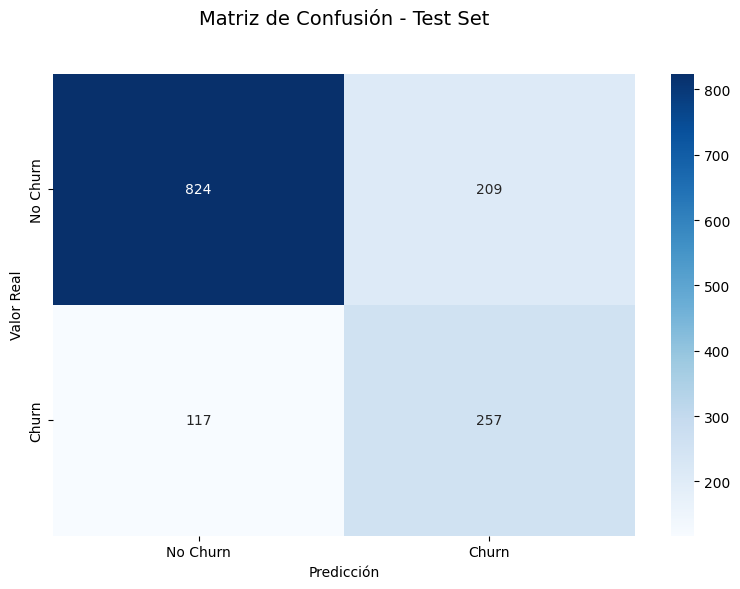

Resultados numéricos:
  • Verdaderos Negativos (TN): 824 (No churn predicho correctamente)
  • Falsos Positivos (FP):     209 (Falsa alarma de churn)
  • Falsos Negativos (FN):     117 (Churn no detectado - ¡CRÍTICO!)
  • Verdaderos Positivos (TP): 257 (Churn detectado correctamente)

Métricas importantes para churn:
  • Precision: 0.552 (De los que predecimos churn, 55.2% era correcto)
  • Recall: 0.687 (Detectamos 68.7% de todos los churns reales)
  • Specificity: 0.798 (Clasificamos bien 79.8% de no-churns)


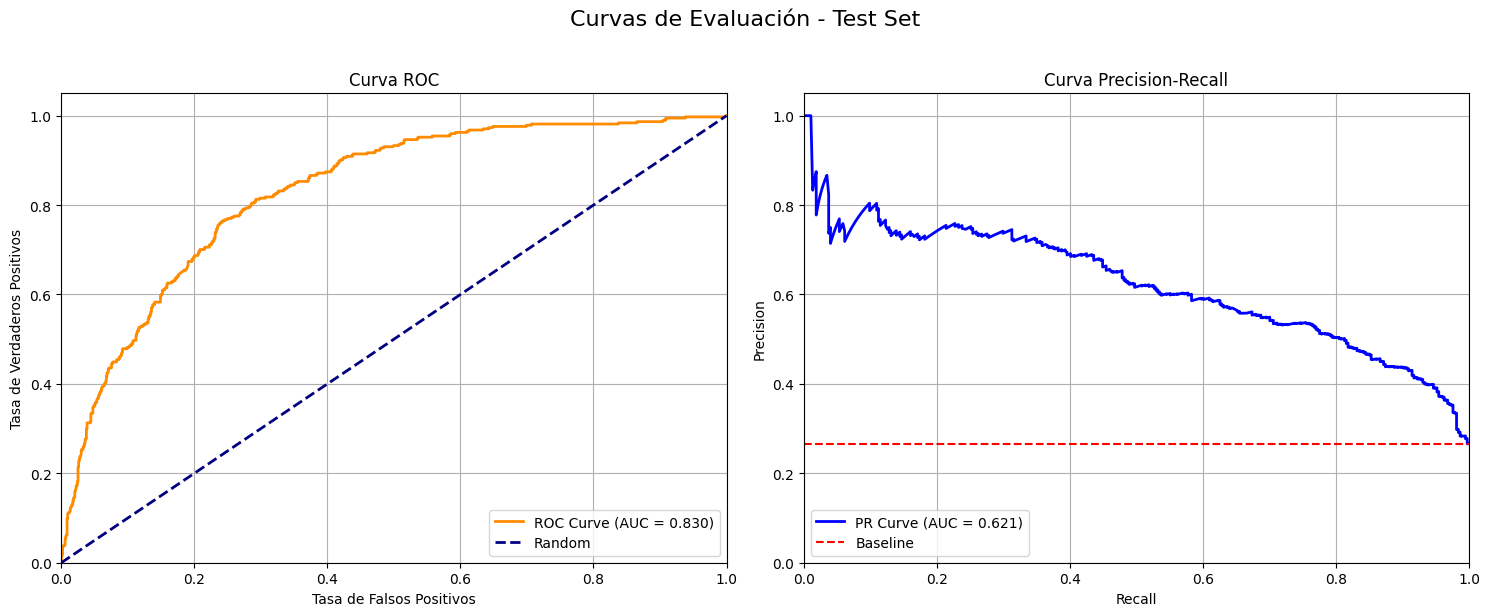


🎯 IMPORTANCIA DE VARIABLES
Top 15 variables más importantes:
 1. customer.tenure                    : 0.2520
 2. account.Contract_Two year          : 0.1292
 3. internet.InternetService_Fiber optic: 0.0996
 4. account.PaymentMethod_Electronic check: 0.0816
 5. account.Contract_One year          : 0.0638
 6. internet.InternetService_No        : 0.0589
 7. internet.TechSupport_Yes           : 0.0331
 8. internet.OnlineSecurity_Yes        : 0.0312
 9. account.PaperlessBilling_Yes       : 0.0303
10. customer.Partner_Yes               : 0.0240
11. internet.OnlineBackup_Yes          : 0.0228
12. customer.gender_Male               : 0.0222
13. customer.Dependents_Yes            : 0.0211
14. customer.SeniorCitizen             : 0.0211
15. phone.MultipleLines_Yes            : 0.0201


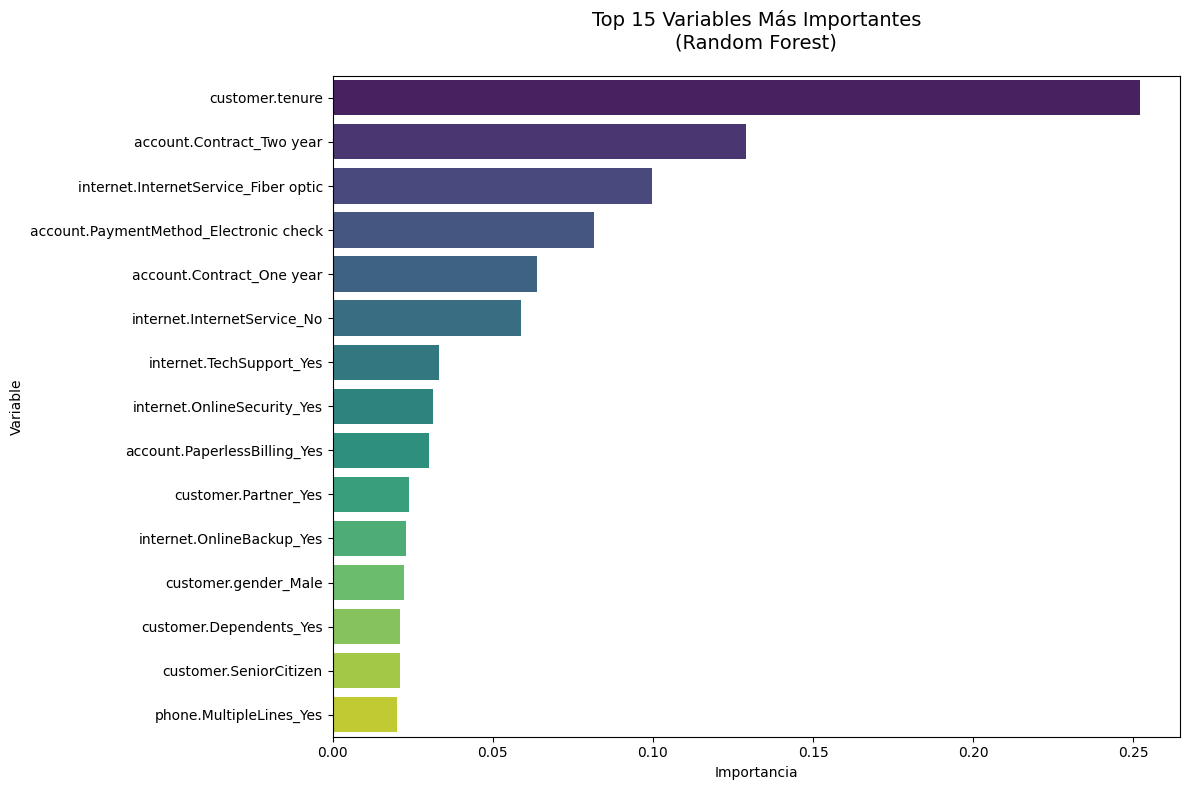


📋 REPORTE FINAL
              precision    recall  f1-score   support

    No Churn       0.88      0.80      0.83      1033
       Churn       0.55      0.69      0.61       374

    accuracy                           0.77      1407
   macro avg       0.71      0.74      0.72      1407
weighted avg       0.79      0.77      0.78      1407



{'modelo': RandomForestClassifier(class_weight='balanced', max_depth=10,
                        min_samples_leaf=2, min_samples_split=5, n_jobs=-1,
                        random_state=42),
 'resultados': {'metricas': {'accuracy': {'train': 0.8394973921289711,
    'test': 0.7683013503909026},
   'precision': {'train': 0.6456692913385826, 'test': 0.5515021459227468},
   'recall': {'train': 0.8777876895628903, 'test': 0.6871657754010695},
   'f1_score': {'train': 0.7440453686200378, 'test': 0.611904761904762},
   'roc_auc': {'train': np.float64(0.9286665435774656),
    'test': np.float64(0.8296910509341464)}}},
 'importancia_variables':                                          Variable  Importancia
 1                                 customer.tenure     0.251957
 15                      account.Contract_Two year     0.129227
 6            internet.InternetService_Fiber optic     0.099622
 18         account.PaymentMethod_Electronic check     0.081644
 14                      account.Cont

In [123]:
def entrenar_random_forest(X_train, X_test, y_train, y_test, X_val=None, y_val=None):
    """
    Entrena Random Forest con class_weight='balanced' y evaluación completa
    """
    print("🌳 ENTRENANDO RANDOM FOREST CLASSIFIER")
    print("="*60)

    # Configuración del modelo
    rf_params = {
        'n_estimators': 100,          # Número de árboles
        'max_depth': 10,              # Profundidad máxima
        'min_samples_split': 5,       # Mínimo para dividir nodo
        'min_samples_leaf': 2,        # Mínimo en hoja
        'class_weight': 'balanced',   # ¡MUY IMPORTANTE para churn!
        'random_state': 42,           # Reproducibilidad
        'n_jobs': -1                  # Usar todos los cores
    }

    print(f"Parámetros del modelo:")
    for param, valor in rf_params.items():
        print(f"  • {param}: {valor}")

    # Entrenar modelo
    print(f"\n🚀 Entrenando...")
    rf_model = RandomForestClassifier(**rf_params)
    rf_model.fit(X_train, y_train)

    print(f"✅ Modelo entrenado con {len(X_train)} muestras")

    return rf_model

def evaluar_modelo_completo(modelo, X_train, X_test, y_train, y_test, X_val=None, y_val=None):
    """
    Evaluación completa del modelo con todas las métricas
    """
    print(f"\n📊 EVALUACIÓN COMPLETA DEL MODELO")
    print("="*50)

    # Predicciones
    y_train_pred = modelo.predict(X_train)
    y_test_pred = modelo.predict(X_test)

    # Probabilidades (para ROC-AUC)
    y_train_proba = modelo.predict_proba(X_train)[:, 1]
    y_test_proba = modelo.predict_proba(X_test)[:, 1]

    resultados = {}

    # ==========================================
    # MÉTRICAS BÁSICAS
    # ==========================================

    print("🎯 MÉTRICAS BÁSICAS:")
    print("-" * 30)

    # Accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    print(f"Accuracy:")
    print(f"  • Train: {train_acc:.4f}")
    print(f"  • Test:  {test_acc:.4f}")

    # Precision
    train_prec = precision_score(y_train, y_train_pred)
    test_prec = precision_score(y_test, y_test_pred)
    print(f"Precision:")
    print(f"  • Train: {train_prec:.4f}")
    print(f"  • Test:  {test_prec:.4f}")

    # Recall (Sensibilidad)
    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)
    print(f"Recall (Sensibilidad):")
    print(f"  • Train: {train_recall:.4f}")
    print(f"  • Test:  {test_recall:.4f}")

    # F1-Score
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    print(f"F1-Score:")
    print(f"  • Train: {train_f1:.4f}")
    print(f"  • Test:  {test_f1:.4f}")

    # ROC-AUC
    train_auc = roc_auc_score(y_train, y_train_proba)
    test_auc = roc_auc_score(y_test, y_test_proba)
    print(f"ROC-AUC:")
    print(f"  • Train: {train_auc:.4f}")
    print(f"  • Test:  {test_auc:.4f}")

    # Guardar métricas
    resultados['metricas'] = {
        'accuracy': {'train': train_acc, 'test': test_acc},
        'precision': {'train': train_prec, 'test': test_prec},
        'recall': {'train': train_recall, 'test': test_recall},
        'f1_score': {'train': train_f1, 'test': test_f1},
        'roc_auc': {'train': train_auc, 'test': test_auc}
    }

    # ==========================================
    # INTERPRETACIÓN DE RESULTADOS
    # ==========================================

    print(f"\n💡 INTERPRETACIÓN:")
    print("-" * 25)

    # Overfitting check
    overfitting = train_acc - test_acc
    if overfitting > 0.1:
        print(f"⚠️  Posible overfitting (diferencia accuracy: {overfitting:.3f})")
    else:
        print(f"✅ Sin overfitting significativo (diferencia: {overfitting:.3f})")

    # Calidad del modelo
    if test_auc > 0.8:
        calidad = "🌟 EXCELENTE"
    elif test_auc > 0.7:
        calidad = "✅ BUENA"
    elif test_auc > 0.6:
        calidad = "⚠️  REGULAR"
    else:
        calidad = "❌ POBRE"

    print(f"Calidad del modelo: {calidad} (AUC: {test_auc:.3f})")

    # Evaluación para churn
    if test_recall > 0.7:
        print(f"✅ Buena detección de churn (Recall: {test_recall:.3f})")
    else:
        print(f"⚠️  Mejorar detección de churn (Recall: {test_recall:.3f})")

    return resultados

def matriz_confusion_detallada(y_true, y_pred, titulo="Matriz de Confusión"):
    """
    Matriz de confusión con interpretación detallada
    """
    print(f"\n🔍 {titulo.upper()}")
    print("="*40)

    cm = confusion_matrix(y_true, y_pred)

    # Crear visualización
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    plt.title(f'{titulo}\n', fontsize=14, pad=20)
    plt.ylabel('Valor Real')
    plt.xlabel('Predicción')
    plt.tight_layout()
    plt.show()

    # Interpretación numérica
    tn, fp, fn, tp = cm.ravel()

    print(f"Resultados numéricos:")
    print(f"  • Verdaderos Negativos (TN): {tn} (No churn predicho correctamente)")
    print(f"  • Falsos Positivos (FP):     {fp} (Falsa alarma de churn)")
    print(f"  • Falsos Negativos (FN):     {fn} (Churn no detectado - ¡CRÍTICO!)")
    print(f"  • Verdaderos Positivos (TP): {tp} (Churn detectado correctamente)")

    # Métricas derivadas
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f"\nMétricas importantes para churn:")
    print(f"  • Precision: {precision:.3f} (De los que predecimos churn, {precision*100:.1f}% era correcto)")
    print(f"  • Recall: {recall:.3f} (Detectamos {recall*100:.1f}% de todos los churns reales)")
    print(f"  • Specificity: {specificity:.3f} (Clasificamos bien {specificity*100:.1f}% de no-churns)")

    return cm

def curvas_roc_y_precision_recall(y_true, y_proba, titulo=""):
    """
    Gráficas de ROC y Precision-Recall
    """
    # Calcular curvas
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    pr_auc = auc(recall, precision)

    # Crear subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # ROC Curve
    ax1.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC Curve (AUC = {roc_auc:.3f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('Tasa de Falsos Positivos')
    ax1.set_ylabel('Tasa de Verdaderos Positivos')
    ax1.set_title('Curva ROC')
    ax1.legend(loc="lower right")
    ax1.grid(True)

    # Precision-Recall Curve
    ax2.plot(recall, precision, color='blue', lw=2,
             label=f'PR Curve (AUC = {pr_auc:.3f})')
    ax2.axhline(y=sum(y_true)/len(y_true), color='red', linestyle='--',
                label='Baseline')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Curva Precision-Recall')
    ax2.legend(loc="lower left")
    ax2.grid(True)

    plt.suptitle(f'Curvas de Evaluación {titulo}', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

    return roc_auc, pr_auc

def importancia_variables_rf(modelo, feature_names, top_n=15):
    """
    Analiza importancia de variables en Random Forest
    """
    print(f"\n🎯 IMPORTANCIA DE VARIABLES")
    print("="*40)

    # Obtener importancias
    importancias = modelo.feature_importances_

    # Crear DataFrame
    feature_importance = pd.DataFrame({
        'Variable': feature_names,
        'Importancia': importancias
    }).sort_values('Importancia', ascending=False)

    # Mostrar top variables
    print(f"Top {top_n} variables más importantes:")
    for i, (_, row) in enumerate(feature_importance.head(top_n).iterrows(), 1):
        print(f"{i:2d}. {row['Variable']:<35}: {row['Importancia']:.4f}")

    # Visualización
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(top_n)

    sns.barplot(data=top_features, x='Importancia', y='Variable', palette='viridis')
    plt.title(f'Top {top_n} Variables Más Importantes\n(Random Forest)', fontsize=14, pad=20)
    plt.xlabel('Importancia')
    plt.tight_layout()
    plt.show()

    return feature_importance

def pipeline_random_forest_completo(X_train, X_test, y_train, y_test, X_val=None, y_val=None):
    """
    Pipeline completo: entrenamiento + evaluación + análisis
    """
    print("🚀 PIPELINE COMPLETO RANDOM FOREST")
    print("="*70)

    # 1. Entrenar modelo
    modelo_rf = entrenar_random_forest(X_train, X_test, y_train, y_test, X_val, y_val)

    # 2. Evaluación completa
    resultados = evaluar_modelo_completo(modelo_rf, X_train, X_test, y_train, y_test, X_val, y_val)

    # 3. Matriz de confusión
    y_test_pred = modelo_rf.predict(X_test)
    matriz_confusion_detallada(y_test, y_test_pred, "Matriz de Confusión - Test Set")

    # 4. Curvas ROC y PR
    y_test_proba = modelo_rf.predict_proba(X_test)[:, 1]
    curvas_roc_y_precision_recall(y_test, y_test_proba, "- Test Set")

    # 5. Importancia de variables
    feature_names = X_train.columns.tolist() if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]
    importancia_df = importancia_variables_rf(modelo_rf, feature_names)

    # 6. Reporte final
    print(f"\n📋 REPORTE FINAL")
    print("="*25)
    y_test_pred = modelo_rf.predict(X_test)
    print(classification_report(y_test, y_test_pred, target_names=['No Churn', 'Churn']))

    return {
        'modelo': modelo_rf,
        'resultados': resultados,
        'importancia_variables': importancia_df,
        'predicciones_test': y_test_pred,
        'probabilidades_test': y_test_proba
    }

pipeline_random_forest_completo(X_train, X_test, y_train, y_test, X_validation, y_validation)

#### 📊 INTERPRETACIÓN COMPLETA - MODELO RANDOM FOREST CHURN

#### 🎯 RESUMEN EJECUTIVO
- **Calidad del modelo**: ⭐⭐⭐⭐⭐ EXCELENTE (AUC: 83%)
- **Problema principal**: Se pierden 31% de clientes que realmente se van
- **Impacto de negocio**: Moderado - Necesita ajustes para maximizar detección

---

#### 📈 ANÁLISIS DETALLADO DE MÉTRICAS

##### ✅ FORTALEZAS DEL MODELO:
1. **AUC excelente (83%)**: El modelo distingue muy bien entre clientes leales y potenciales churns
2. **No overfitting**: Diferencia train-test aceptable (7.1%)
3. **Variables lógicas**: Los predictores más importantes tienen sentido de negocio

##### ⚠️ ÁREAS DE MEJORA:
1. **Recall bajo (68.7%)**:
   - **Problema**: De cada 100 clientes que se van, solo detecta 69
   - **Impacto**: Se pierden 31 clientes por cada 100 que se van
   - **Costo**: Alto - estos son ingresos perdidos

2. **Precision moderada (55.2%)**:
   - **Problema**: De cada 100 alertas de churn, 45 son falsas alarmas
   - **Impacto**: Recursos desperdiciados en retención innecesaria

---

#### 💼 IMPACTO DE NEGOCIO

##### 📊 Traducción a números reales:
Si tienes **1000 clientes que se van** al mes:
- ✅ **Detectarás**: 687 clientes
- ❌ **Se te escaparán**: 313 clientes
- 💸 **Costo de oportunidad**: Ingresos perdidos de 313 clientes

##### 🎯 Matriz de confusión interpretada:
```
REALIDAD vs PREDICCIÓN (Test Set):
┌─────────────────┬──────────────┬──────────────┐
│                 │ Pred: Quedan │ Pred: Se van │
├─────────────────┼──────────────┼──────────────┤
│ Real: Quedan    │     824 ✅   │    209 ⚠️    │
│ Real: Se van    │     117 🚨   │    257 ✅    │
└─────────────────┴──────────────┴──────────────┘

🚨 CRÍTICO: 117 clientes se van sin ser detectados
⚠️ COSTO: 209 falsas alarmas (esfuerzo de retención innecesario)
```

---

#### 🔍 INSIGHTS CLAVE DE VARIABLES

##### 🥇 TOP PREDICTORES Y SU SIGNIFICADO:

1. **customer.tenure (25.2%)**
   - **Insight**: Antiguedad del cliente es EL factor más importante
   - **Acción**: Programas especiales para clientes nuevos (0-12 meses)

2. **account.Contract_Two year (12.9%)**
   - **Insight**: Contratos largos = alta lealtad
   - **Acción**: Incentivos para migrar a contratos de 2 años

3. **internet.InternetService_Fiber optic (10%)**
   - **Insight**: Clientes de fibra óptica tienden a irse más
   - **Acción**: Revisar calidad de servicio en fibra óptica

4. **account.PaymentMethod_Electronic check (8.2%)**
   - **Insight**: Método de pago riesgoso
   - **Acción**: Migrar clientes a métodos automáticos

##### 📋 PERFIL DEL CLIENTE EN RIESGO:
- ✅ **Tenure bajo** (nuevos clientes)
- ✅ **Contrato mes a mes**
- ✅ **Servicio fibra óptica**
- ✅ **Pago por cheque electrónico**
- ✅ **Sin servicios adicionales** (tech support, online security)

---

#### 🎯 RECOMENDACIONES ESTRATÉGICAS

##### 🚀 MEJORAS DEL MODELO:
1. **Ajustar threshold**: Bajar umbral de decisión para aumentar Recall
2. **Balancear datos**: Usar técnicas como SMOTE para equilibrar clases
3. **Probar otros modelos**: XGBoost, ensemble methods
4. **Feature engineering**: Crear variables derivadas (tiempo desde último pago, etc.)

##### 💼 ACCIONES DE NEGOCIO INMEDIATAS:

###### 🎯 **RETENCIÓN PROACTIVA:**
- Monitoreo especial a clientes con < 12 meses
- Ofertas de migración a contratos anuales/bianuales
- Programa de seguimiento para clientes fibra óptica

###### 📞 **SEGMENTACIÓN PARA RETENCIÓN:**
- **Alta prioridad**: tenure < 6 meses + contrato mensual
- **Media prioridad**: fibra óptica + pago electrónico
- **Seguimiento**: clientes sin servicios adicionales

###### 💰 **OPTIMIZACIÓN DE COSTOS:**
- Cost-benefit analysis: ¿Cuánto cuesta retener vs perder un cliente?
- Ajustar intensidad de retención según probabilidad de churn

---

#### 📊 MÉTRICAS DE ÉXITO PROPUESTAS

##### KPIs para monitorear:
1. **Recall mejorado**: Target 75%+ (actualmente 68.7%)
2. **Precision equilibrada**: Mantener 50%+
3. **Reducción de churn**: Medir impacto real en tasas de cancelación
4. **ROI de retención**: Ingresos salvados vs costo de programas

##### 🔄 Ciclo de mejora continua:
1. Implementar modelo actual
2. Medir resultados reales durante 3 meses
3. Re-entrenar con nuevos datos
4. Ajustar estrategias según feedback del negocio

---

#### ✅ CONCLUSIÓN ESTRATÉGICA

**El modelo es SÓLIDO con AUC de 83%**, pero necesita ajustes para maximizar la detección de clientes que realmente se van.

**Prioridad #1**: Mejorar Recall para reducir clientes perdidos no detectados.

**El modelo identifica correctamente los factores de riesgo** - ahora toca actuar sobre ellos tanto algorítmicamente como en el negocio.

# 📓 **INFORME**

## INTRODUCCIÓN

Todos los sectores empresariales se ven afectados por la exigencia de la competitividad, y el sector de las telecomunicaciones no es la excepción. En particular, la retención de clientes se ha convertido en uno de los desafíos más críticos para la sostenibilidad del negocio. El fenómeno del *churn* o abandono de clientes representa no solo una pérdida directa de ingresos, sino también un incremento significativo en los costos de adquisición de nuevos clientes para compensar las bajas.

Teniendo en cuenta ese impacto, la empresa Telecom X ha decidido hacer un análisis de ese fenómeno en su empresa en aras de encontrar aspectos que le puedan ayudar a tener tasas bajas de abondono y a mejorar el servicio no solo para sus clientes actuales sino para atraer clientes nuevos. De igual forma, lograr comprender los factores subyacentes que impulsan el abandono le va a permitir a la empresa diseñar estrategias de retención efectivas, optimizar la asignación de recursos y mejorar la experiencia general del cliente, contribuyendo así a la estabilidad y crecimiento del negocio a largo plazo.

En el presente informe se detalle el análisis del *churn*, con una pequeña introducción del análisis descriptivos de los datos utilizados así como de los problemas encontrados y sus respectivas correcciones. Posterior, se detalle las correcciones realizadas sobre los datos para poder realizar un análisis predictivo. Finalmente, se detallan los resultados con dos modelos predicitivos: el análisis de regresión logísitca y el *random forest*.

## OBJETIVO

Este proyecto tiene como objetivo principal desarrollar un sistema predictivo robusto capaz de identificar con anticipación qué clientes tienen mayor probabilidad de cancelar sus servicios de telecomunicaciones. A través de técnicas avanzadas de machine learning, buscamos proporcionar a la empresa una herramienta estratégica que permita implementar acciones preventivas y personalizadas para reducir la tasa de churn.

## METODOLOGÍA

La metodología seguida incluye:

- **Análisis Exploratorio y Preparación de Datos:** Limpieza, tratamiento de valores faltantes y codificación de variables categóricas.
- **Análisis de Correlación:** Identificación de las variables más relevantes para la predicción del churn.
- **Desarrollo de Modelos:** Implementación y comparación de algoritmos de clasificación.
- **Evaluación de Performance:** Análisis exhaustivo utilizando múltiples métricas de evaluación.
- **Interpretación de Resultados:** Identificación de los factores más influyentes en la decisión de abandono.

## DESCRIPCIÓN DE LOS DATOS

El conjunto de datos facilitado por la empresa contiene un total de 7267 registros y un total de 21 columnas. Las columnas recolectan información que describen el perfil del usuario en los siguientes grupos:

| Sociodemográfico | Servicio de telefonía | Servicio de internet | Cuenta
|------------------|-----------------------||-----------------------|
| Género | Tiene de servicio de telefonía | Tiene servicio de internet | Tipo contrato
| Ciudadano adulto mayor | Tiene múltiples líneas | Tiene seguridad en línea | Factura electrónica
| Tiene pareja | | Tiene backup en línea | Método de pago
| Tiene dependientes | | Tiene protección de dispositivos | Cargos mensuales
| Tiempo como cliente | | Tiene soporte técnico | Cargos totales
| | | Tiene Streaming TV
| | | Tiene Películas Streaming




### Preparación de los datos

En el primer análisis realizado sobre la variable de interés *Churn*, se encuentran 224 filas con datos vacíos en esta columna, y se decide eliminar esos registros. No se imputan puesto que al ser la variable de interés no resulta plausible crear valores que puedan distorsionar de lo realmente observado en los datos.

Por otra lado, se encuentra que en la variable *Tenure* hay datos con valor 0. Al revisar esos registros se encuentra que en todos el valor de la variable *Churn* es 'No'. Lo cual indica que son todos clientes nuevos, por tanto se decide eliminarlos dado que su perfil no representa información significativa para el análisis objetivo.

Ahora, variables como *Multiple Lines* o *Online Security* tienen dentro de sus categorías variables que caegorizan a aquellos clientes que no cuentan con ese servicio, por ejemplo, 'no phone service' representaría aquellos clientes que no tiene servicio de telefóno y por tanto no responden 'si' o 'no' a tener múltiples líneas. Sin embargo, esa categoría resultaría en redudancia en el análisis, por ello, se reemplazan esos valores en las respectivas variables.

También se eliminan las variables *customerID* y la variable *account.Charges.Total*. La primera se elimina, ya que al hacer el identificador de los registros no representa información para el análisis que se pretende realizar. Y la última, porque además de presentar valores vacíos, está relacionada con la variable que tiene el cálculo de los cargos por mes, y para evitar esa redundancia se opta por eliminar la última variable mencionada.

Lo último que se revisa en los datos es el balanceo de los datos de la variable de interés, obteniéndose que de los 7032 registros que quedaron después de los procesos realizados y mencionados en los párrafos anteriores, 5163 registros representaban el 'No' y 1869 tienen valor 'Si'.

Según la literatura, si la razón del grupo mayoritario sobre el grupo menor es menor o igual a 3, se considera que hay un desbalance moderado de los datos. Para tratar ese problema se decide utilizar el parámetro `class_weight='balanced'` para la elaboración de los modelos predictivos.


### Resumen descriptivo

En relación al perfil socidemográfico de los cliente se observa que es menos probable que un cliente que tenga dependientes y pareja se retire del servicio. El género tiene una diferencia mínima. Y de los clientes que pertenecen a la población adulto mayor tienen mayor probabilidad de retirarse.


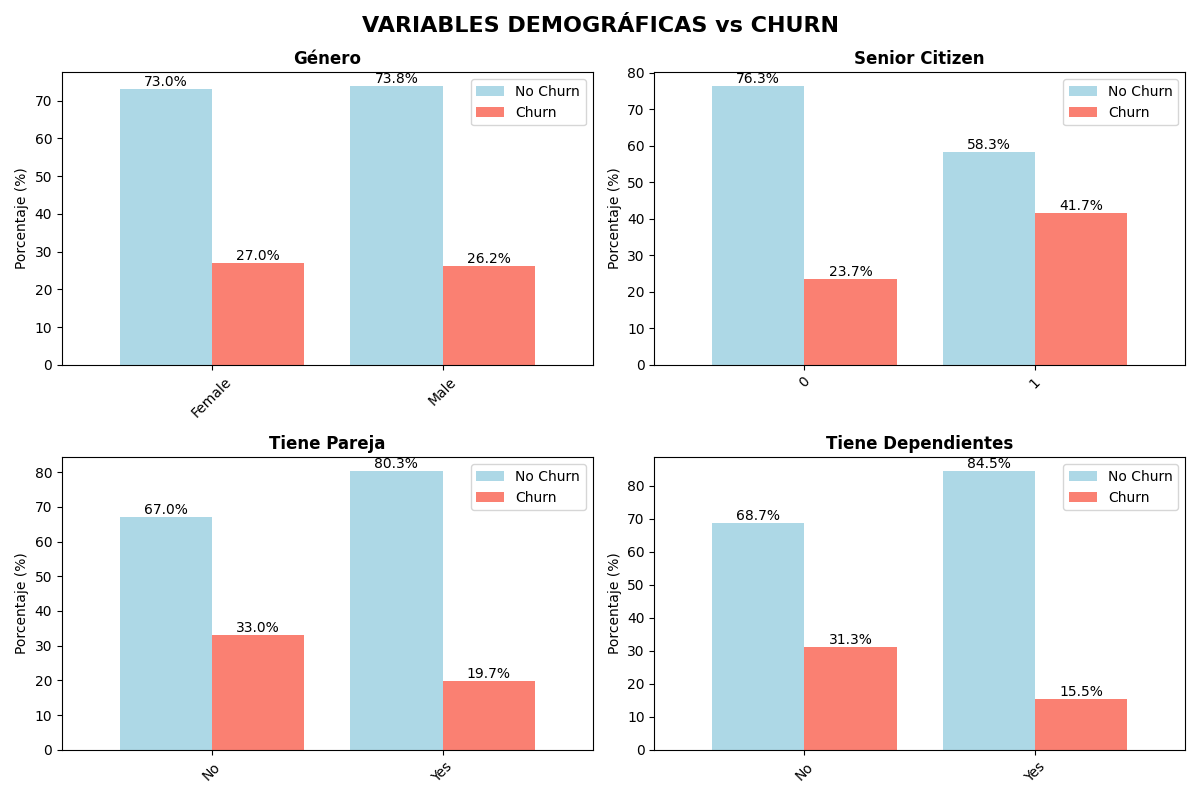

In [115]:
display(Image(filename='var_demograficas_churn.png'))

En cuanto a los servicios telefónicos, no se observa diferencia significativa en ninguno de los casos. Pero en los servicios de internet si se observan características importantes. La primera es la gran proporción de clientes de fibra óptica que se han retirado.

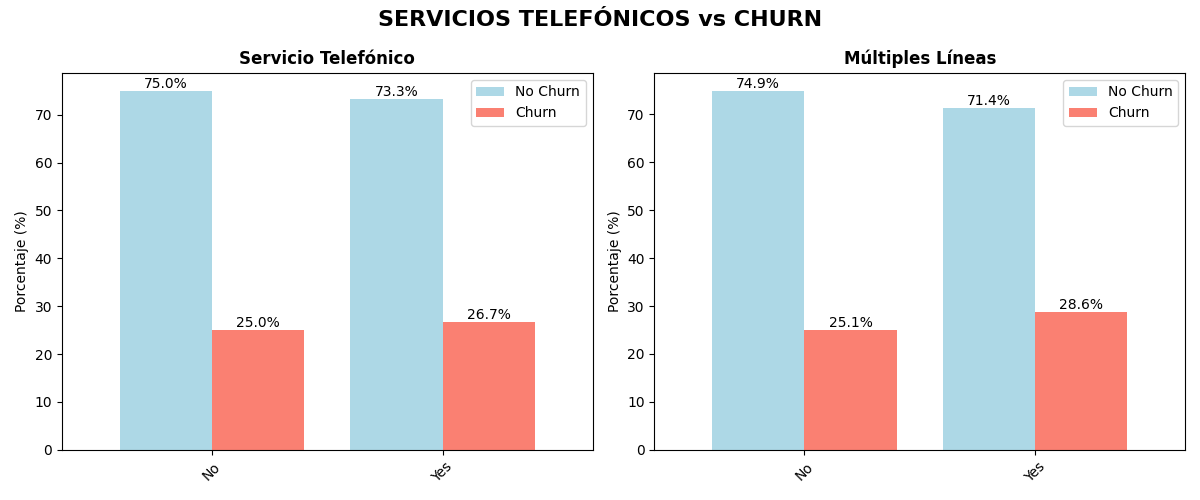

In [116]:
display(Image(filename='serv_telefonicos_churn.png'))

Y en los servicios adicionales al internet, se observa como el que el cliente no los tenga aumenta la frecuencia de retiros, en la mayoría de las variables. Solo en dos sucede lo contrario: Streaming TV y Streaming Películas, lo cual puede suceder por el efecto de una mala fibra óptica que afecte esos servicios.

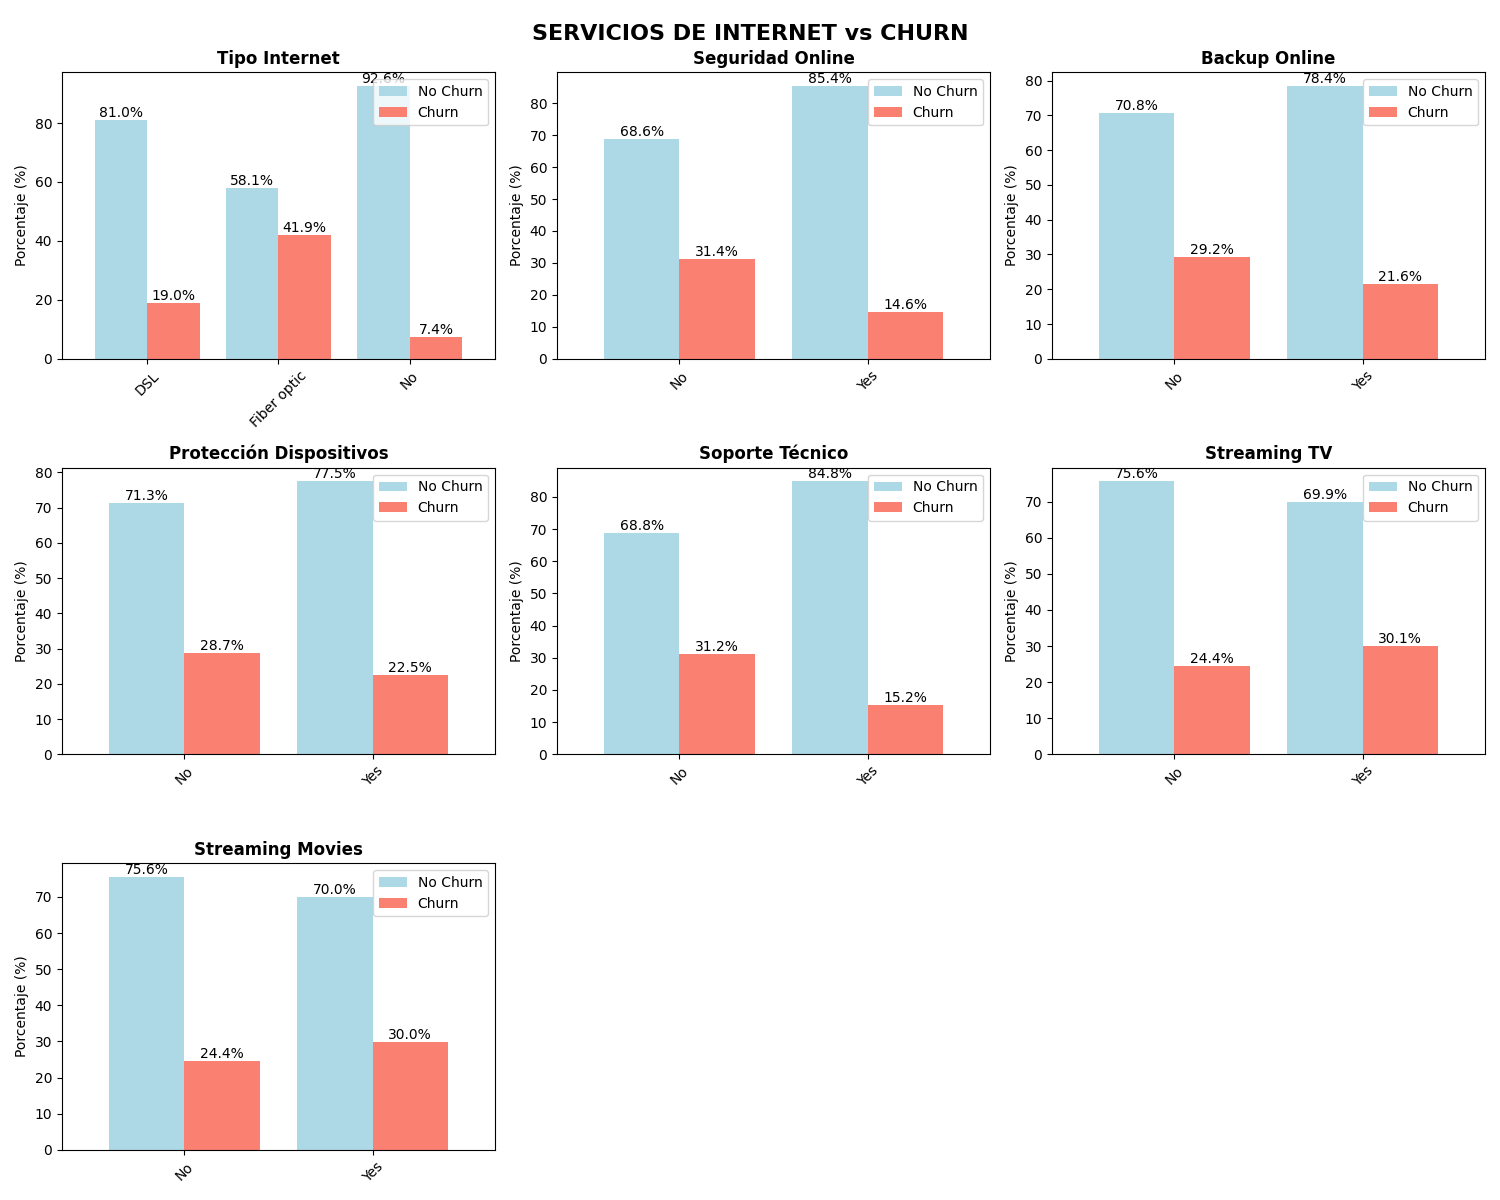

In [117]:
display(Image(filename='serv_internet_churn.png'))

En lo relacionado a la cuenta, los datos muestran que clientes con contratos de mes a mes son más propensos a retirarse, así como los que han solicitado factura digital, indicando un problema con este tipo de facturación. Y sobre el método de pago, el cheque electrónico es el método donde se han registrado mayor número de retiros.

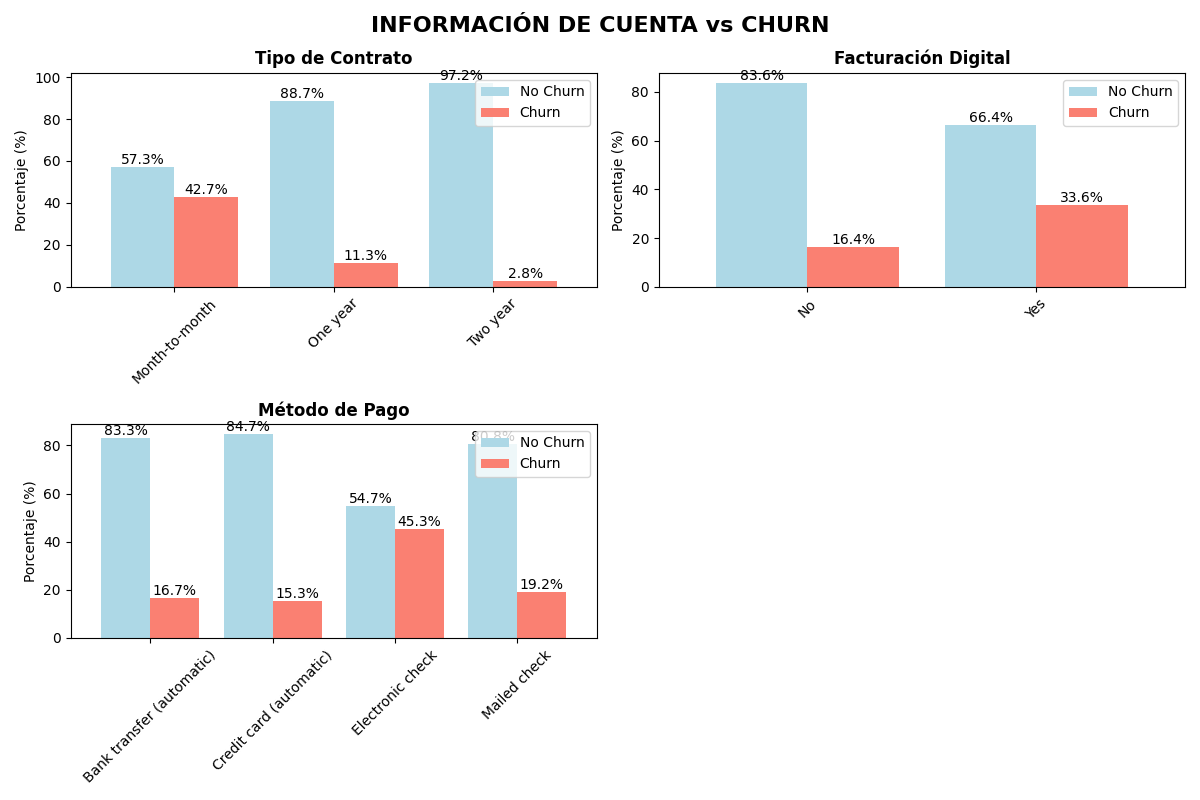

In [118]:
display(Image(filename='account_churn.png'))

Por último, sobre la dos variables numéricas, tiempo como cliente y cargos mensuales, se observa que en relación a la primera variable los clientes con menor tiempo de permanencia tienen una mayor frecuencia en el retiro. Ahora, sucede un comportamiento interesante en los cargos mensuales, a pesar que el valor del tercer cuartil es cercano tanto para los que se han retirado como para los que no, el valor del primer cuartil si presenta una diferencia marcada. Los clientes que han hecho churn tiene un rango de cargos mensuales menor y de valores altos.

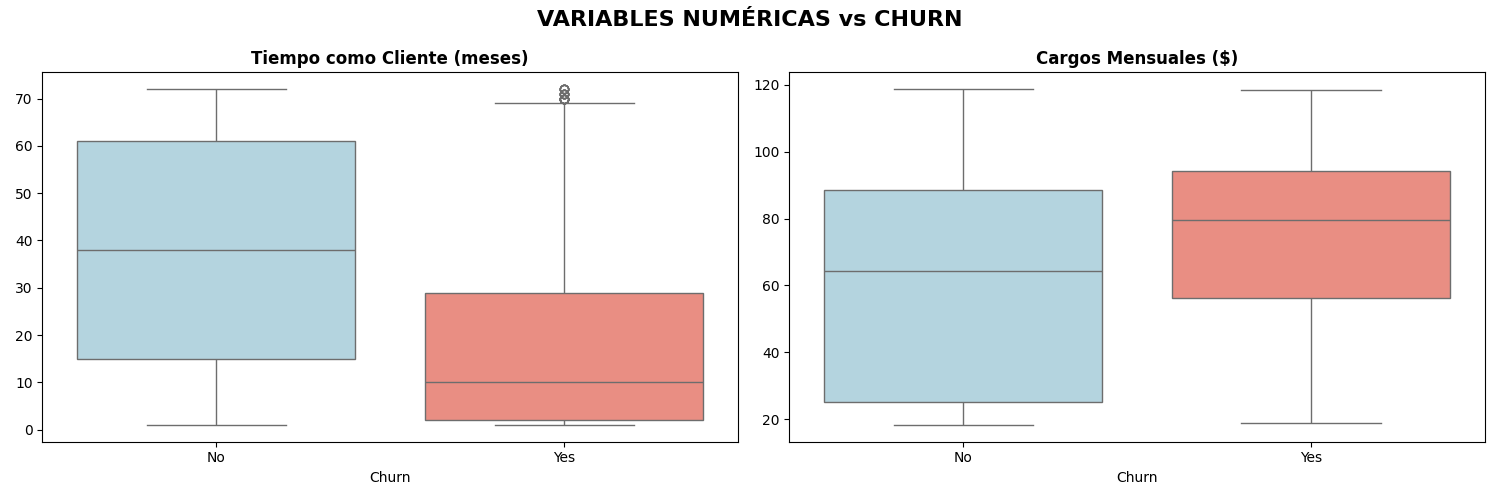

In [119]:
display(Image(filename='var_numericas_churn.png'))

## PREPROCESAMIENTO DE LOS DATOS PARA MODELOS PREDICTIVOS

No solo la variable de interés es una variable categórica, como se ha venido mostrando la mayoría de las variables asociadas al fenómeno son categóricas. Por tanto, para garantizar el funcionamiento del algoritmo y la buena estimación del modelo, en el caso particular del modelo de regresión logística, se debe codificar las categorías de esas variables con números (0 - 1), y crear las diversas varaibles dummies correspondientes.

Para la variable de intereés *Churn* se utilizó el método LabelEncoder(), para la demás variables categóricas se utilizó la técnica OneHotEncoder(). Se utiliza LabelEncoder para la variable objetivo porque simplemente reemplaza los valores de las categorías por 0 y 1 sin crear columnas adicionales. Por su parte en las variables que influyen se utilizó el OneHotEncoder porque hay variables con más de dos categorías y porque no se quiere que el algoritmo piense que hay una categoría con mayor peso, sino que las tome por iguales.

Posterior a ello, se realizó el mismo *encoding* pero sobre un conjunto donde las variables estuvieran escaladas. Esto porque cálculos como el VIF y el modelo de regresión logística se comporta mejor con los datos escalados, especialmente cuando los valores pueden ser muy amplios. En este caso, la variable de costos mensuales tenía valores mucho más grandes que la variable de de tiempo como cliente (tenure). Sin embargo, se recalca que se utilizaron ambos conjuntos creados, con la varaibles numéricas escaladas y sin escalar, cuyas razones se explicarán posteriormente.

Por último se crearon los subconjuntos de datos requeridos: entrenamientos, prueba y validación con porcentajes del 60% - 20% - 20% respectivamente.

## ANÁLISIS DE LA CORRELACIÓN


Un aspecto importante a verificar para la creación de los modelos predictivos es la correlación de las variables dependientes con la variable independiete, pues es este valor el que da una idea del nivel de explicación que puede ofrecer en el suceso observado y medido.

Para el análisis de correlación se utiliza el conjunto de datos sin escalar para observar la realidad de lo manifestado por los datos.

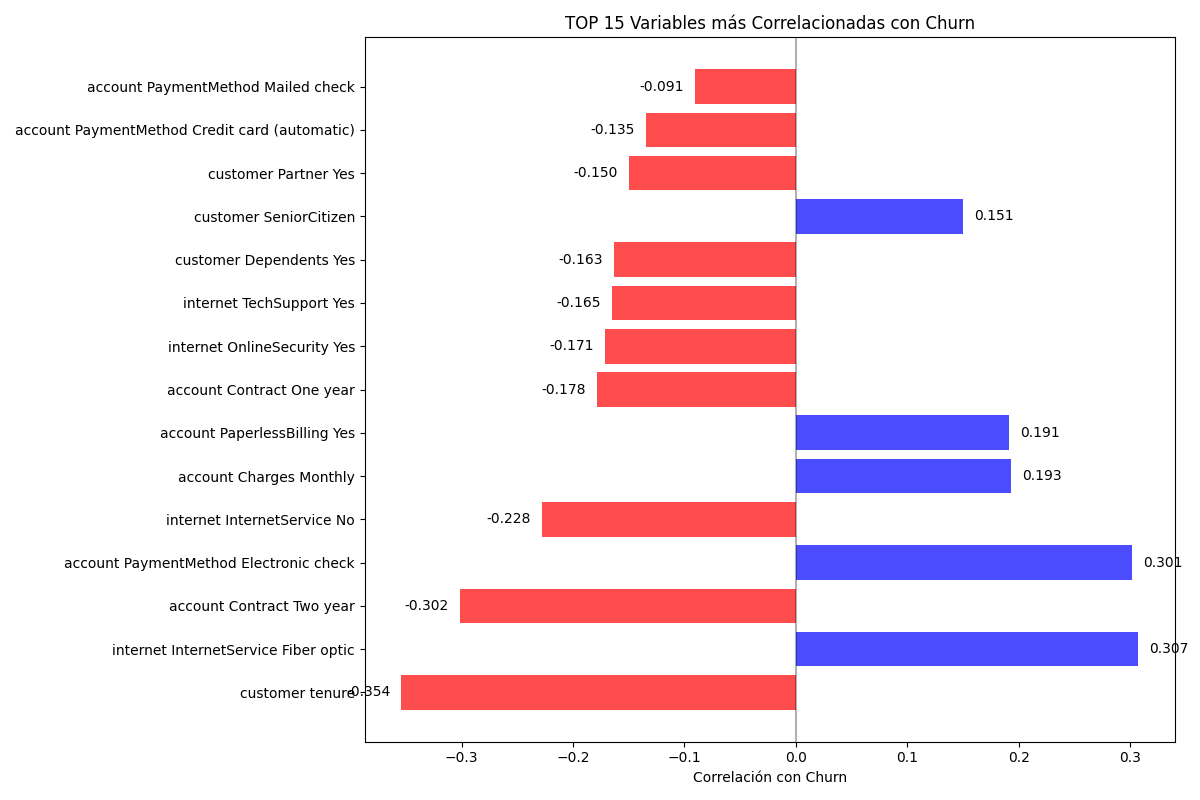

In [120]:
display(Image(filename='corr_churn.png'))

En problemas de Churn, correlaciones de 0.2-0.4 son consideradas moderadas a fuertes. Raramente se ven correlaciones >0.5 porque el comportamiento humano es complejo.

En este sentido, según el análisis de correlación de las variables dependientes con la la variable independiente (Churn), hay correlaciones bastante buenas para el análisis.

**Correlaciones negativas fuertes (factores protectores):**

- customer.tenure (-0.354): Clientes con más tiempo tienden a quedarse
- account.Contract_Two year (-0.302): Contratos largos reducen el churn
- internet.InternetService_No (-0.228): No tener internet reduce probabilidad de irse

**Correlaciones positivas fuertes (factores de riesgo):**

- internet.InternetService_Fiber optic (0.307): Fibra óptica aumenta churn
- account.PaymentMethod_Electronic check (0.301): Este método de pago es riesgoso



## ANÁLISIS DE MULTICOLINEALIDAD

De igual forma, es importante verificar que no haya correlaciones altas entre la variables dependientes, porque esto puede generar redundancia en el modelo y hacerlo menos efectivo.

Lo primero que se hace es calcular la matriz de correlaciones. A sabiendas que ese valor es invariante al escalado, y que el escalado puede afectar la interpretación, se utilizarán los datos sin escalar con el fin de observar las relaciones "naturales" entre esas variables.

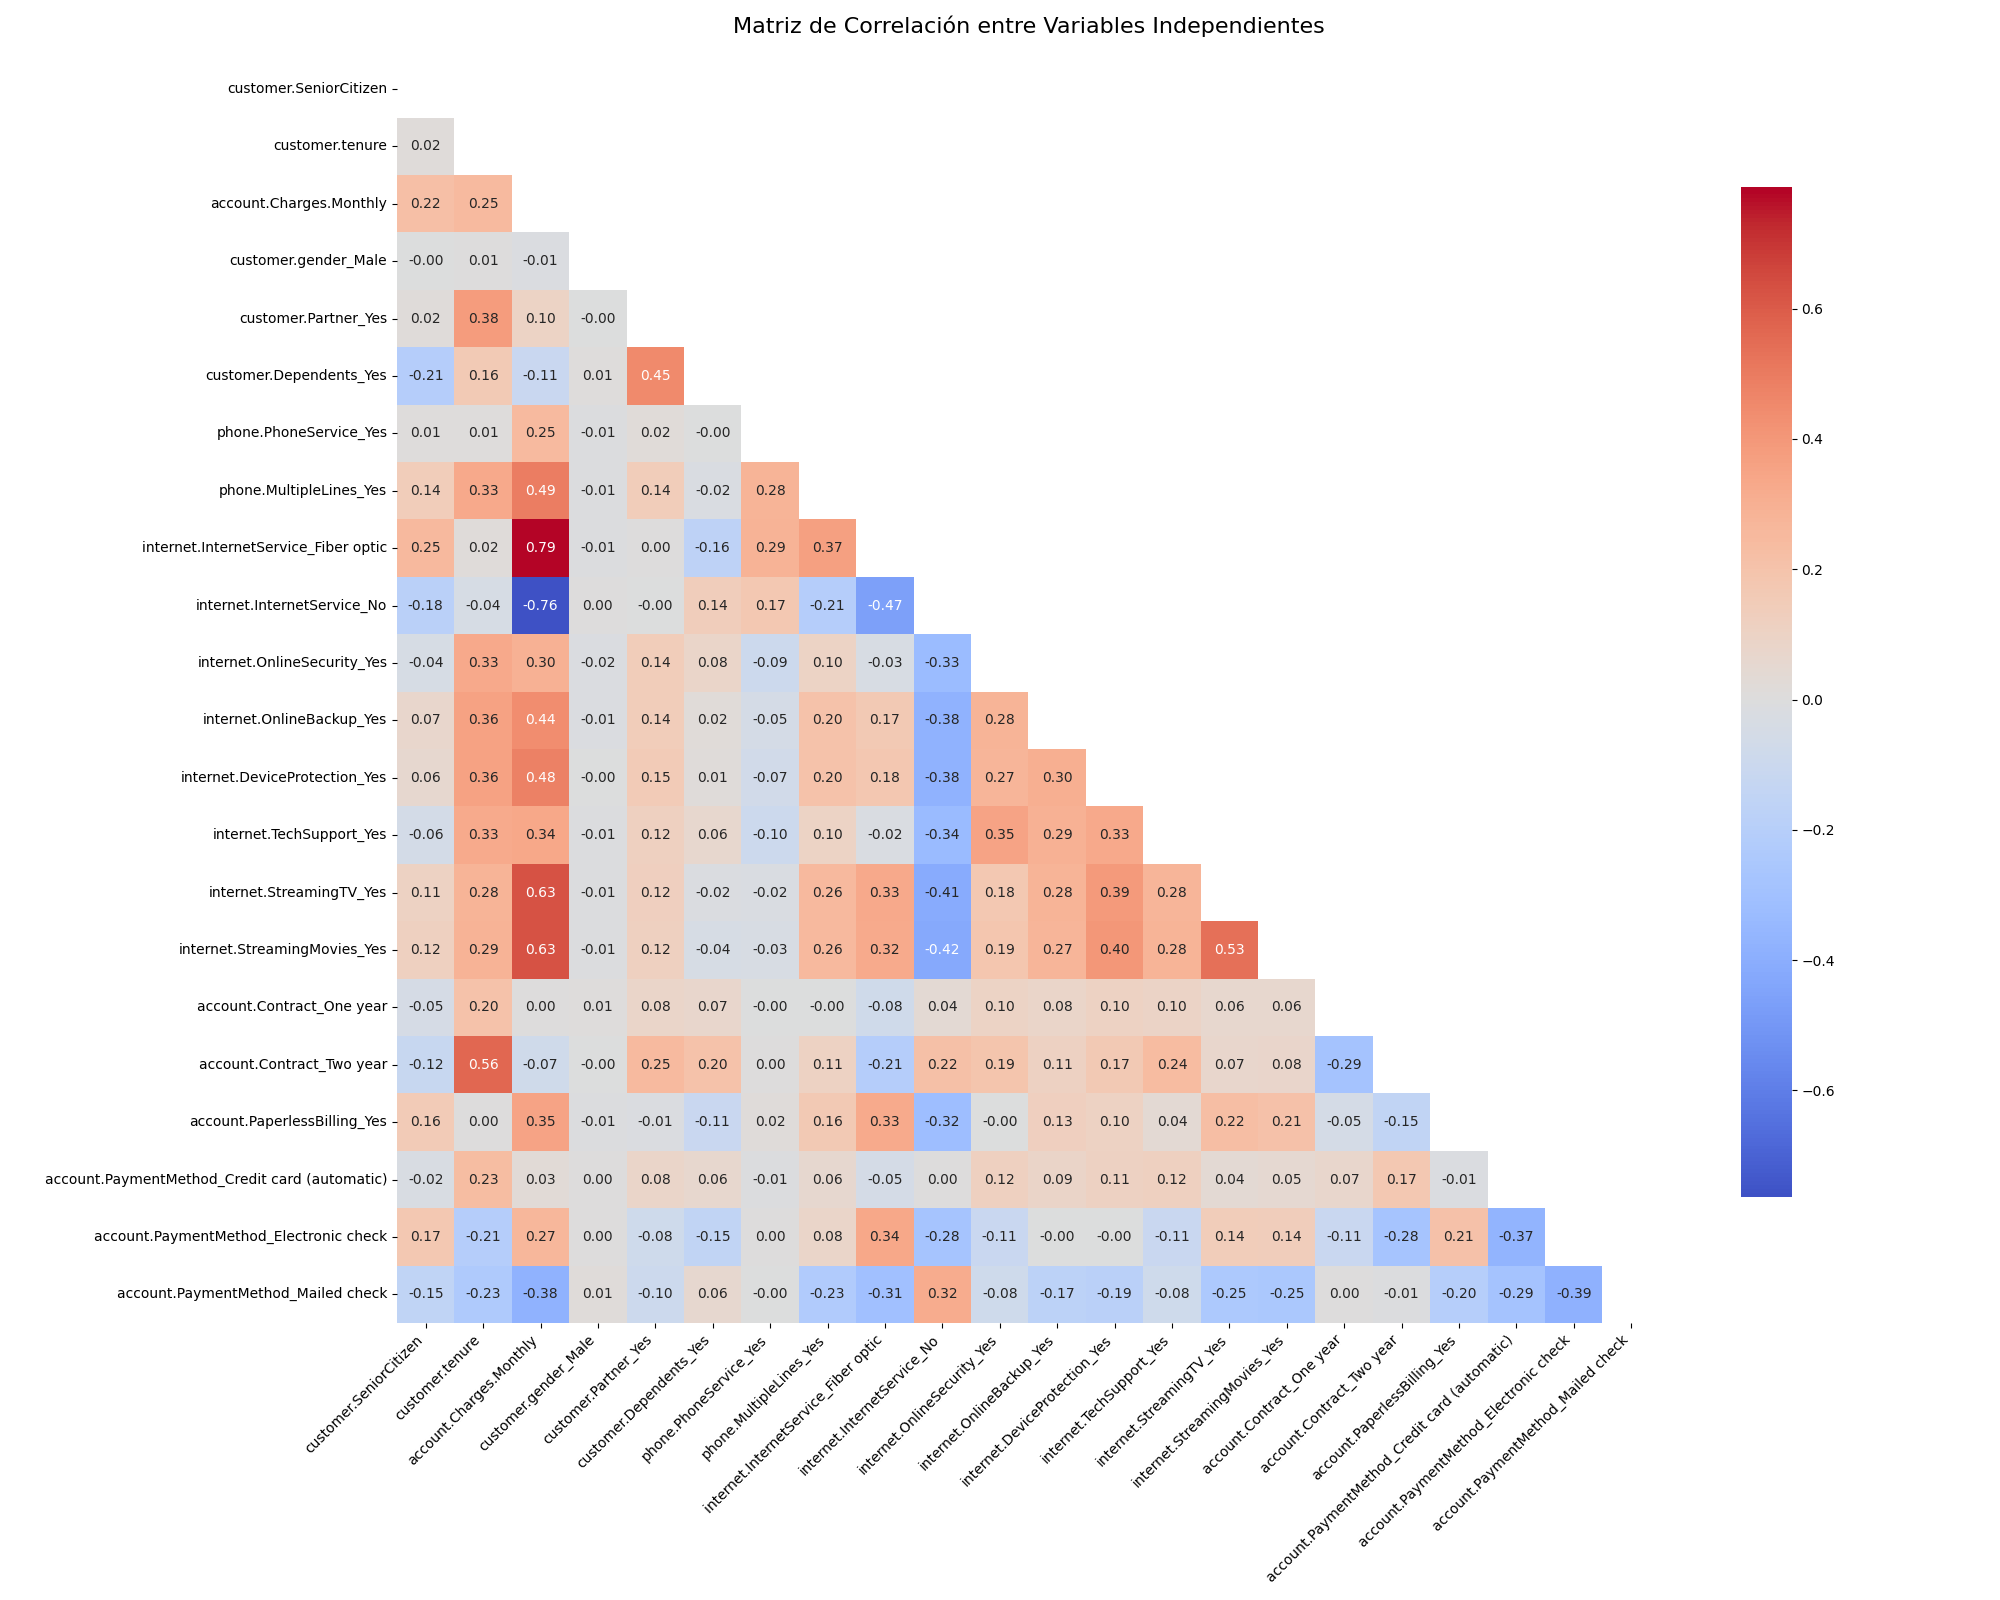

In [121]:
display(Image(filename="matrix_corr.png"))

Se observa que hay correlaciones altas (>0.7) en los pares de variables *account.Charges.Monthly* y *internet.InternetService_Fiber optic*, así como en el par *account.Charges.Monthly* y *internet.InternetService_No*


Por su parte, al calcular el VIF usando los datos escalados se obtiene que hay cuatro variables a revisar:
- *account.Charges.Monthly* - VIF: 13.28 - PROBLEMÁTICA
- *phone.PhoneService_Yes* - VIF: 10.14 - PROBLEMÁTICA
- *internet.InternetService_Fiber optic* - VIF: 7.44 - ALTA
- *internet.InternetService_No* - VIF: 6.59 - ALTA


De lo cual se deduce la necesidad de eliminar algunas variables. Se analiza el efecto de cada una de esas variables sobre la variable objetivo y se decide eliminarVariables a eliminar *phone.PhoneService_Yes* y *account.Charges.Monthly*. Se calcula de nuevo el VIF y se obtiene valores adecuados, especialmente para las otras variables que presentaban un VIF alto: *internet.InternetService_Fiber optic* e *internet.InternetService_No*, con VIF de 2.87 y 2.47 respectivamente.

Eliminando esas variables se crean de nuevo los subconjuntos de entrenamiento, prueba y validación.

## MODELO DE REGRESIÓN LOGÍSTICA

MÉTRICAS DE EVALUACIÓN COMPARATIVAS

|                     | Train |  Test | Validation |
|---------------------|-------|-------|------------|
|Accuracy              |0.755  |0.748      |0.749
|Precision             |0.526  |0.518      |0.519
|Recall (Sensitivity)  |0.800  |0.765      |0.786
|F1-Score              |0.635  |0.618      |0.625
|ROC-AUC               |0.851  |0.828      |0.840
|Avg Precision         |0.660  |0.613      |0.640
|Specificity           |0.739  |0.742      |0.736

Según la tabla de métricas, con un ROC-AUC = 0.828, el modelo tiene una muy buena capacidad discriminativa. Puede distinguir eficazmente entre clientes que se van y los que se quedan. Además, los resultados son consistentes entre train/test/validation (no hay overfitting significativo).

- **Recall = 76.5%** (Lo más importante en churn) El modelo detecta correctamente 3 de cada 4 clientes que realmente se van Esto es crucial porque el costo de perder un cliente suele ser alto.

- **Precision = 51.8%** De los clientes que el modelo predice como "churn", solo el 52% realmente se va. Significa que tendrás algunos "falsos positivos" (clientes que no se van pero tu modelo predice que sí).

🔍 **Análisis de las Matrices de Confusión en el conjunto de Test:**

- Verdaderos Positivos: 286 (churn detectado correctamente)
- Falsos Negativos: 88 (churn no detectado - ¡estos son costosos!)
- Falsos Positivos: 266 (alarmas falsas)
- Verdaderos Negativos: 767 (no-churn correctamente identificado)

💼 **Implicaciones de Negocio**

✅ *Fortalezas:*
- Captura la mayoría de clientes en riesgo (76.5%)
- Buen balance general (F1 = 0.618)
- Modelo estable y confiable

⚠️ *Consideraciones:*
- Se deberían hacer campañas de retención dirigidas a algunos clientes que no se iban a ir (falsos positivos)
- Aún se "escapan" 1 de cada 4 clientes que se van



## MODELO DE RANDOM FOREST

#### 🎯 RESUMEN EJECUTIVO
- **Calidad del modelo**: ⭐⭐⭐⭐⭐ EXCELENTE (AUC: 83%)
- **Problema principal**: Se pierden 31% de clientes que realmente se van
- **Impacto de negocio**: Moderado - Necesita ajustes para maximizar detección

---

#### 📈 ANÁLISIS DETALLADO DE MÉTRICAS

##### ✅ FORTALEZAS DEL MODELO:
1. **AUC excelente (83%)**: El modelo distingue muy bien entre clientes leales y potenciales churns
2. **No overfitting**: Diferencia train-test aceptable (7.1%)
3. **Variables lógicas**: Los predictores más importantes tienen sentido de negocio

##### ⚠️ ÁREAS DE MEJORA:
1. **Recall bajo (68.7%)**:
   - **Problema**: De cada 100 clientes que se van, solo detecta 69
   - **Impacto**: Se pierden 31 clientes por cada 100 que se van
   - **Costo**: Alto - estos son ingresos perdidos

2. **Precision moderada (55.2%)**:
   - **Problema**: De cada 100 alertas de churn, 45 son falsas alarmas
   - **Impacto**: Recursos desperdiciados en retención innecesaria

---

#### 💼 IMPACTO DE NEGOCIO

##### 📊 Traducción a números reales:
Si tienes **1000 clientes que se van** al mes:
- ✅ **Detectarás**: 687 clientes
- ❌ **Se te escaparán**: 313 clientes
- 💸 **Costo de oportunidad**: Ingresos perdidos de 313 clientes

##### 🎯 Matriz de confusión interpretada:
```
REALIDAD vs PREDICCIÓN (Test Set):
┌─────────────────┬──────────────┬──────────────┐
│                 │ Pred: Quedan │ Pred: Se van │
├─────────────────┼──────────────┼──────────────┤
│ Real: Quedan    │     824 ✅   │    209 ⚠️    │
│ Real: Se van    │     117 🚨   │    257 ✅    │
└─────────────────┴──────────────┴──────────────┘

🚨 CRÍTICO: 117 clientes se van sin ser detectados
⚠️ COSTO: 209 falsas alarmas (esfuerzo de retención innecesario)
```

---

#### 🔍 INSIGHTS CLAVE DE VARIABLES

##### 🥇 TOP PREDICTORES Y SU SIGNIFICADO:

1. **customer.tenure (25.2%)**
   - **Insight**: Antiguedad del cliente es EL factor más importante
   - **Acción**: Programas especiales para clientes nuevos (0-12 meses)

2. **account.Contract_Two year (12.9%)**
   - **Insight**: Contratos largos = alta lealtad
   - **Acción**: Incentivos para migrar a contratos de 2 años

3. **internet.InternetService_Fiber optic (10%)**
   - **Insight**: Clientes de fibra óptica tienden a irse más
   - **Acción**: Revisar calidad de servicio en fibra óptica

4. **account.PaymentMethod_Electronic check (8.2%)**
   - **Insight**: Método de pago riesgoso
   - **Acción**: Migrar clientes a métodos automáticos

##### 📋 PERFIL DEL CLIENTE EN RIESGO:
- ✅ **Tenure bajo** (nuevos clientes)
- ✅ **Contrato mes a mes**
- ✅ **Servicio fibra óptica**
- ✅ **Pago por cheque electrónico**
- ✅ **Sin servicios adicionales** (tech support, online security)

---

#### 🎯 RECOMENDACIONES ESTRATÉGICAS

##### 🚀 MEJORAS DEL MODELO:
1. **Ajustar threshold**: Bajar umbral de decisión para aumentar Recall
2. **Balancear datos**: Usar técnicas como SMOTE para equilibrar clases
3. **Probar otros modelos**: XGBoost, ensemble methods
4. **Feature engineering**: Crear variables derivadas (tiempo desde último pago, etc.)

##### 💼 ACCIONES DE NEGOCIO INMEDIATAS:

###### 🎯 **RETENCIÓN PROACTIVA:**
- Monitoreo especial a clientes con < 12 meses
- Ofertas de migración a contratos anuales/bianuales
- Programa de seguimiento para clientes fibra óptica

###### 📞 **SEGMENTACIÓN PARA RETENCIÓN:**
- **Alta prioridad**: tenure < 6 meses + contrato mensual
- **Media prioridad**: fibra óptica + pago electrónico
- **Seguimiento**: clientes sin servicios adicionales

###### 💰 **OPTIMIZACIÓN DE COSTOS:**
- Cost-benefit analysis: ¿Cuánto cuesta retener vs perder un cliente?
- Ajustar intensidad de retención según probabilidad de churn

---

#### 📊 MÉTRICAS DE ÉXITO PROPUESTAS

##### KPIs para monitorear:
1. **Recall mejorado**: Target 75%+ (actualmente 68.7%)
2. **Precision equilibrada**: Mantener 50%+
3. **Reducción de churn**: Medir impacto real en tasas de cancelación
4. **ROI de retención**: Ingresos salvados vs costo de programas

##### 🔄 Ciclo de mejora continua:
1. Implementar modelo actual
2. Medir resultados reales durante 3 meses
3. Re-entrenar con nuevos datos
4. Ajustar estrategias según feedback del negocio

---

#### ✅ CONCLUSIÓN ESTRATÉGICA

**El modelo es SÓLIDO con AUC de 83%**, pero necesita ajustes para maximizar la detección de clientes que realmente se van.

**Prioridad #1**: Mejorar Recall para reducir clientes perdidos no detectados.

**El modelo identifica correctamente los factores de riesgo** - ahora toca actuar sobre ellos tanto algorítmicamente como en el negocio.

## COMPARACIÓN Y SELECCCIÓN DEL MODELO

## Análisis Comparativo de Modelos

### Métricas de Performance

| Métrica | Regresión Logística | Random Forest | Interpretación |
|---------|-------------------|---------------|----------------|
| **ROC-AUC** | 82.8% | 83.0% | Capacidad discriminativa similar y excelente |
| **Recall** | **76.5%** | 68.7% | **RL detecta más clientes que se van** |
| **Precision** | 51.8% | **55.2%** | **RF genera menos falsas alarmas** |
| **F1-Score** | **61.8%** | 61.8% | Balance general idéntico |

### Análisis de Matrices de Confusión

#### Regresión Logística (Test Set):
- **Clientes perdidos no detectados**: 88 (23.5% de los que se van)
- **Falsas alarmas**: 266 clientes

#### Random Forest (Test Set):
- **Clientes perdidos no detectados**: 117 (31.3% de los que se van)
- **Falsas alarmas**: 209 clientes

## Evaluación desde Perspectiva de Negocio

### Costos Asociados

**Costo de un Falso Negativo (Cliente perdido no detectado):**
- Pérdida de ingresos mensuales durante la vida útil del cliente
- Costo de adquisición de cliente de reemplazo
- Impacto estimado: **ALTO** (5-10x mayor que un falso positivo)

**Costo de un Falso Positivo (Falsa alarma):**
- Recursos gastados en campaña de retención innecesaria
- Posible molestia al cliente por contacto no requerido
- Impacto estimado: **MEDIO-BAJO**

### Análisis de Impacto

#### Regresión Logística:
- ✅ **Detecta 29 clientes adicionales** que realmente se van (vs Random Forest)
- ❌ **Genera 57 falsas alarmas adicionales**
- 💰 **ROI superior** considerando que evitar un churn real vale más que el costo de una falsa alarma

#### Random Forest:
- ✅ **Menos falsas alarmas** (mayor eficiencia operativa)
- ✅ **Mejor interpretabilidad** de importancia de variables
- ❌ **Pierde más clientes valiosos** sin detectar



## EXPLICACIÓN SELECCIÓN



Se recomienda utilizar el modelo generado por la regresión logística. La Regresión Logística es el modelo óptimo para esta implementación inicial debido a su superior capacidad de detección de churn real (Recall = 76.5%), menor complejidad operativa y mejor alineación con los objetivos de negocio. Su implementación permitirá capturar 3 de cada 4 clientes que realmente están en riesgo de cancelación, maximizando el impacto en la retención y los ingresos de la empresa.

### Justificación Estratégica

**1. Priorización del Recall en Churn Prediction**

En el contexto de telecomunicaciones, **el costo de perder un cliente es significativamente mayor** que el costo de contactarlo preventivamente. La Regresión Logística, con un Recall superior (76.5% vs 68.7%), es más efectiva en cumplir el objetivo principal: **minimizar la pérdida de clientes**.

**2. Impacto Económico**

Asumiendo un valor de vida del cliente (CLV) promedio y costos de campaña de retención:
- **29 clientes adicionales salvados** por la RL generan un valor económico sustancialmente mayor
- **57 falsas alarmas adicionales** representan un costo operativo manejable

**3. Estabilidad y Confiabilidad**

- **Menor complejidad** facilita el mantenimiento y actualización del modelo
- **Resultados consistentes** entre conjuntos de entrenamiento, prueba y validación
- **Mayor robustez** ante cambios en los patrones de datos

### Estrategia de Implementación Recomendada

**Fase 1: Implementación con Regresión Logística**
- Despliegue del modelo para identificación de clientes en riesgo
- Configuración de campanhas de retención automatizadas
- Monitoreo de métricas clave (Recall real, ROI de retención)

**Fase 2: Optimización Operativa**
- Ajuste de threshold de decisión basado en resultados iniciales
- Segmentación de acciones de retención según probabilidad de churn
- Análisis de cost-benefit real para calibrar intensidad de campañas

**Fase 3: Mejora Continua**
- Re-entrenamiento mensual con datos actualizados
- A/B testing de diferentes estrategias de retención
- Evaluación de modelos híbridos o ensemble methods

### Consideraciones para Random Forest

Aunque no se recomienda como modelo principal, **Random Forest aporta valor complementario**:

- **Análisis de importancia de variables** más detallado para insights de negocio
- **Modelo de validación** para confirmar predicciones críticas
- **Candidato para ensemble** en futuras iteraciones



## RECOMENDACIONES ESTRATÉGICAS

### Implementación Inmediata
1. **Despliegue del Sistema Predictivo**

Implementar la Regresión Logística como motor de predicción principal
Establecer proceso automatizado de scoring mensual de la base de clientes
Configurar alertas para clientes que superen el threshold de riesgo establecido

2. **Programa de Retención Diferenciada**

Clientes nuevos (0-6 meses): Programa de seguimiento intensivo y beneficios de bienvenida extendidos
Usuarios fibra óptica: Revisión de calidad de servicio y planes de mejora técnica
Contratos mensuales: Incentivos para migración a contratos anuales o bianuales

###Iniciativas de Mediano Plazo
3. **Mejora de Productos y Servicios**

Evaluar y mejorar la experiencia del servicio de fibra óptica
Desarrollar paquetes atractivos de servicios adicionales (seguridad online, soporte técnico)
Simplificar y promover métodos de pago automáticos

4. **Optimización del Modelo**

Monitoreo continuo de performance y re-calibración trimestral
Incorporación de nuevas variables predictoras (comportamiento de uso, interacciones de servicio al cliente)
Exploración de modelos ensemble para mejorar precisión

###Métricas de Seguimiento
- KPIs Operativos:

  - Tasa de churn mensual general
  - Efectividad de campañas de retención (% de clientes retenidos post-intervención)
  - Precisión del modelo en predicciones reales

- KPIs de Negocio:

  - Valor de clientes retenidos (CLV preserved)
  - ROI de programas de retención
  - Reducción del costo de adquisición de clientes

## CONCLUSIÓN

Este proyecto establece una base sólida para la gestión proactiva del churn en la empresa de telecomunicaciones. La implementación del modelo de Regresión Logística, combinada con las estrategias de retención recomendadas, posicionará a la empresa para:

- Reducir significativamente la pérdida de clientes mediante identificación temprana y acciones preventivas
- Optimizar la inversión en retención focalizando recursos en clientes con mayor riesgo real
- Mejorar la experiencia del cliente al abordar proactivamente los factores de insatisfacción identificados

El éxito de esta iniciativa dependerá de la implementación consistente, el monitoreo continuo y la adaptación ágil a los cambios del mercado. Con estos elementos en su lugar, la empresa estará equipada con una ventaja competitiva significativa en la retención de clientes y la sostenibilidad de sus ingresos a largo plazo.

La inversión en este sistema predictivo no solo representa una mejora operativa, sino una transformación hacia una cultura de datos y decisiones basadas en evidencia que beneficiará múltiples áreas del negocio más allá de la simple retención de clientes.